In [2]:
import metpy
import datetime
import rioxarray
import os
import glob
import warnings

import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature

from plotting import histogram_density_plot

In [3]:
df = pd.read_csv('data/matched-with-met-era5-land-no-nans.csv', parse_dates=['time'])

In [6]:
df.drop(['POC', 'proj_longitude', 'proj_latitude'], axis=1, inplace=True)

In [7]:
df

,longitude,latitude,time,value,AOD,u10,v10,d2m,t2m,lai_hv,lai_lv,sp,tp
0,-117.675930,33.630030,2021-01-01,3.700000,0.026075,-1.077633,-2.977906,276.775940,282.467194,4.608634e+00,2.416980,100737.046875,0.000000
1,-117.617220,34.030833,2021-01-01,8.758333,0.046046,-1.076965,-1.760517,273.029663,276.600128,4.555422e+00,2.070768,97802.726562,0.000000
2,-117.492010,34.100020,2021-01-01,3.800000,0.074804,-0.904657,-2.349114,272.379242,276.591034,4.981341e+00,0.500358,95819.882812,0.000000
3,-117.416010,33.999580,2021-01-01,1.422222,0.052775,-1.145754,-1.622866,272.269165,275.956177,4.973994e+00,0.491314,96718.757812,0.000000
4,-117.325540,34.510961,2021-01-01,10.158333,0.073041,-0.221437,-2.697097,269.582184,274.981140,2.384186e-07,0.521381,91697.023438,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130766,-77.012816,38.875161,2021-12-31,5.745833,0.240285,0.400340,0.966632,283.148590,283.212402,1.631318e+00,2.021581,100870.195312,0.000079
130767,-76.958072,38.895572,2021-12-31,5.612500,0.294921,0.400340,0.966632,283.148590,283.212402,1.631318e+00,2.021581,100870.195312,0.000079
130768,-76.953426,38.894770,2021-12-31,7.837500,0.418024,0.400340,0.966632,283.148590,283.212402,1.631318e+00,2.021581,100870.195312,0.000079
130769,-76.059210,43.052350,2021-12-31,12.216667,0.211089,-1.173805,0.852107,275.288666,275.378418,1.200389e+00,1.946690,99466.679688,0.000289


In [8]:
regions = gpd.read_file('data/ne_50m_admin_1_states_provinces.zip')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

In [9]:
texas = contiguous_us[contiguous_us.name == 'Texas']

In [10]:
plate = ccrs.PlateCarree()
ds.rio.write_crs(plate.to_string(), inplace=True)
clipped = ds.rio.clip(texas.geometry.apply(mapping))

In [11]:
minlon, minlat, maxlon, maxlat = texas.bounds.values.ravel()

In [12]:
texas_df = df[(df.longitude >= minlon) & (df.longitude <= maxlon) & (df.latitude >= minlat) & (df.latitude <= maxlat)]
lons, lats = [], []
for (lon, lat), _ in texas_df.groupby(['longitude', 'latitude']):
    lons.append(lon)
    lats.append(lat)

In [13]:
from shapely.geometry import Point
pairs = list(map(Point, zip(lons, lats)))

In [14]:
texas_points = [(p.x, p.y) for p in pairs if texas.contains(p).item()]
lons, lats = list(zip(*texas_points))

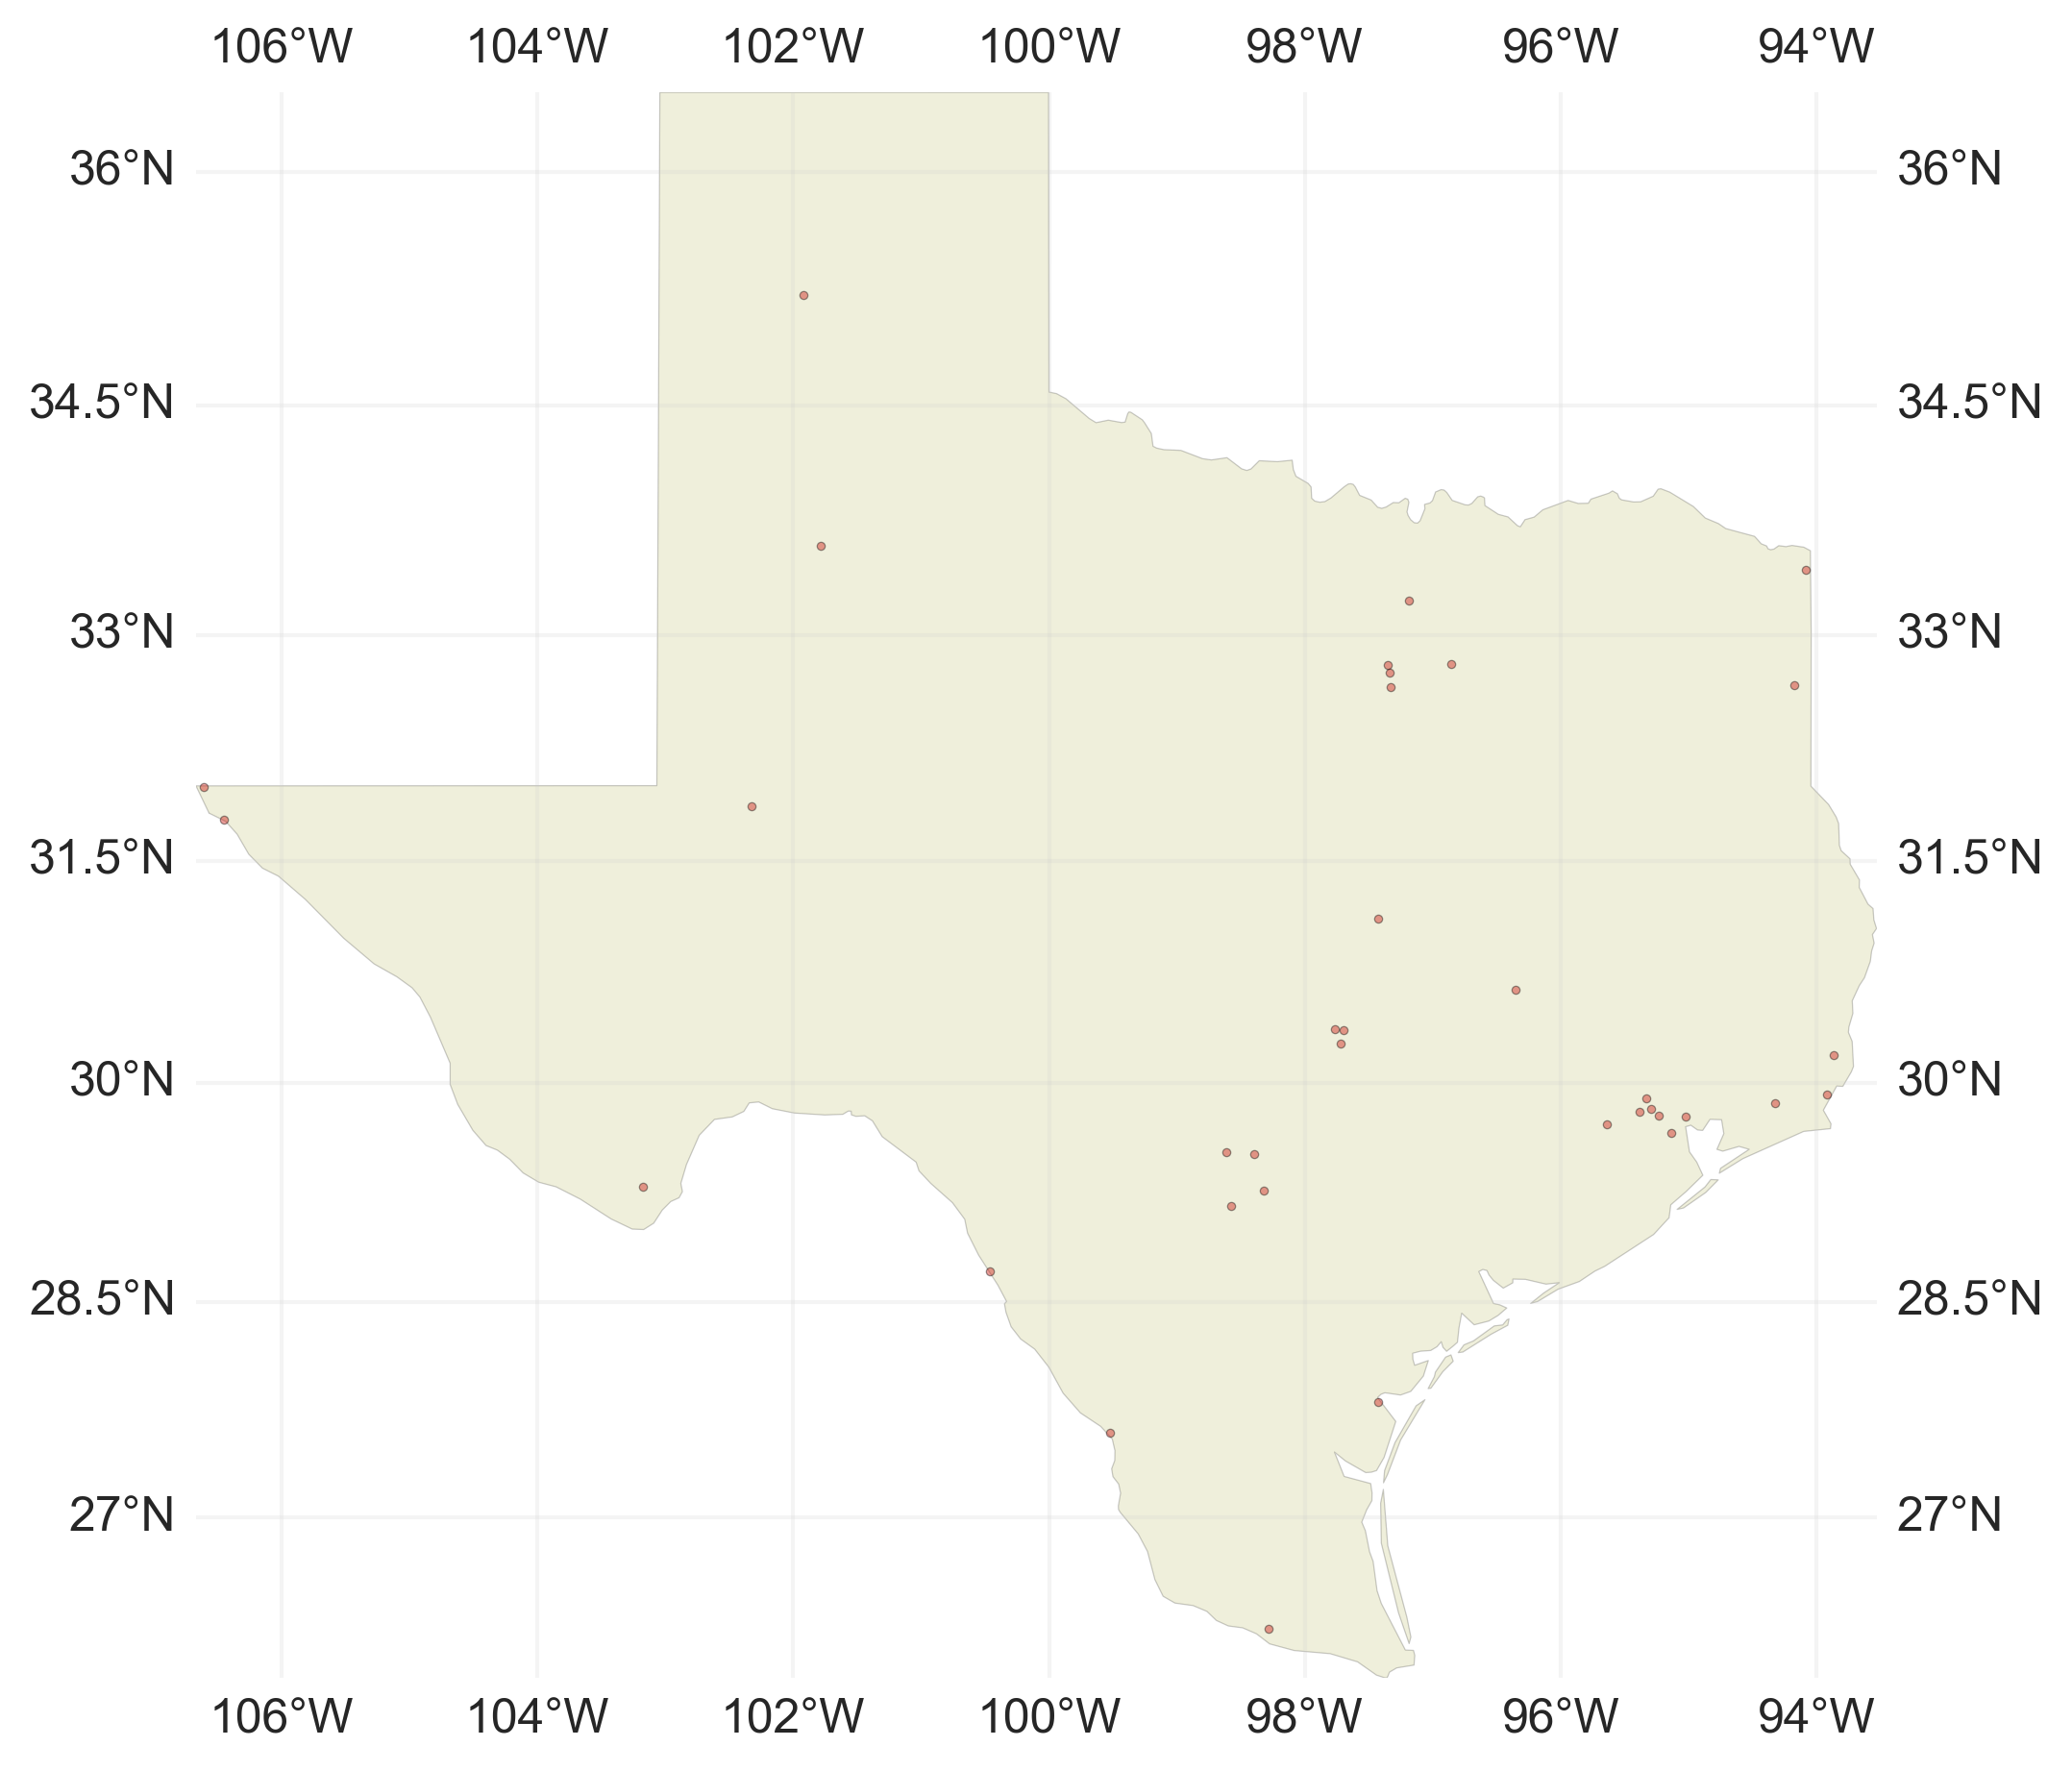

In [15]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)

# ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.set_extent([minlon, maxlon, minlat, maxlat], plate)

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

ax.add_geometries(
    texas.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state)


ax.scatter(lons, lats,
       s=4, 
       alpha=0.4, 
       c='r',
       edgecolor='black',
       transform=ccrs.PlateCarree(), 
       zorder=10);

# for lon, lat in zip(lons, lats):
#     ax.text(lon,
#             lat + 0.05,
#             f'{lon:.2f}, {lat:.2f}',
#             ha='center',
#             va='bottom',
#             transform=ccrs.PlateCarree(),
#             fontsize=2)

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)

In [16]:
lons, lats = [], []
for (lon, lat), _ in df.groupby(['longitude', 'latitude']):
    lons.append(lon)
    lats.append(lat)

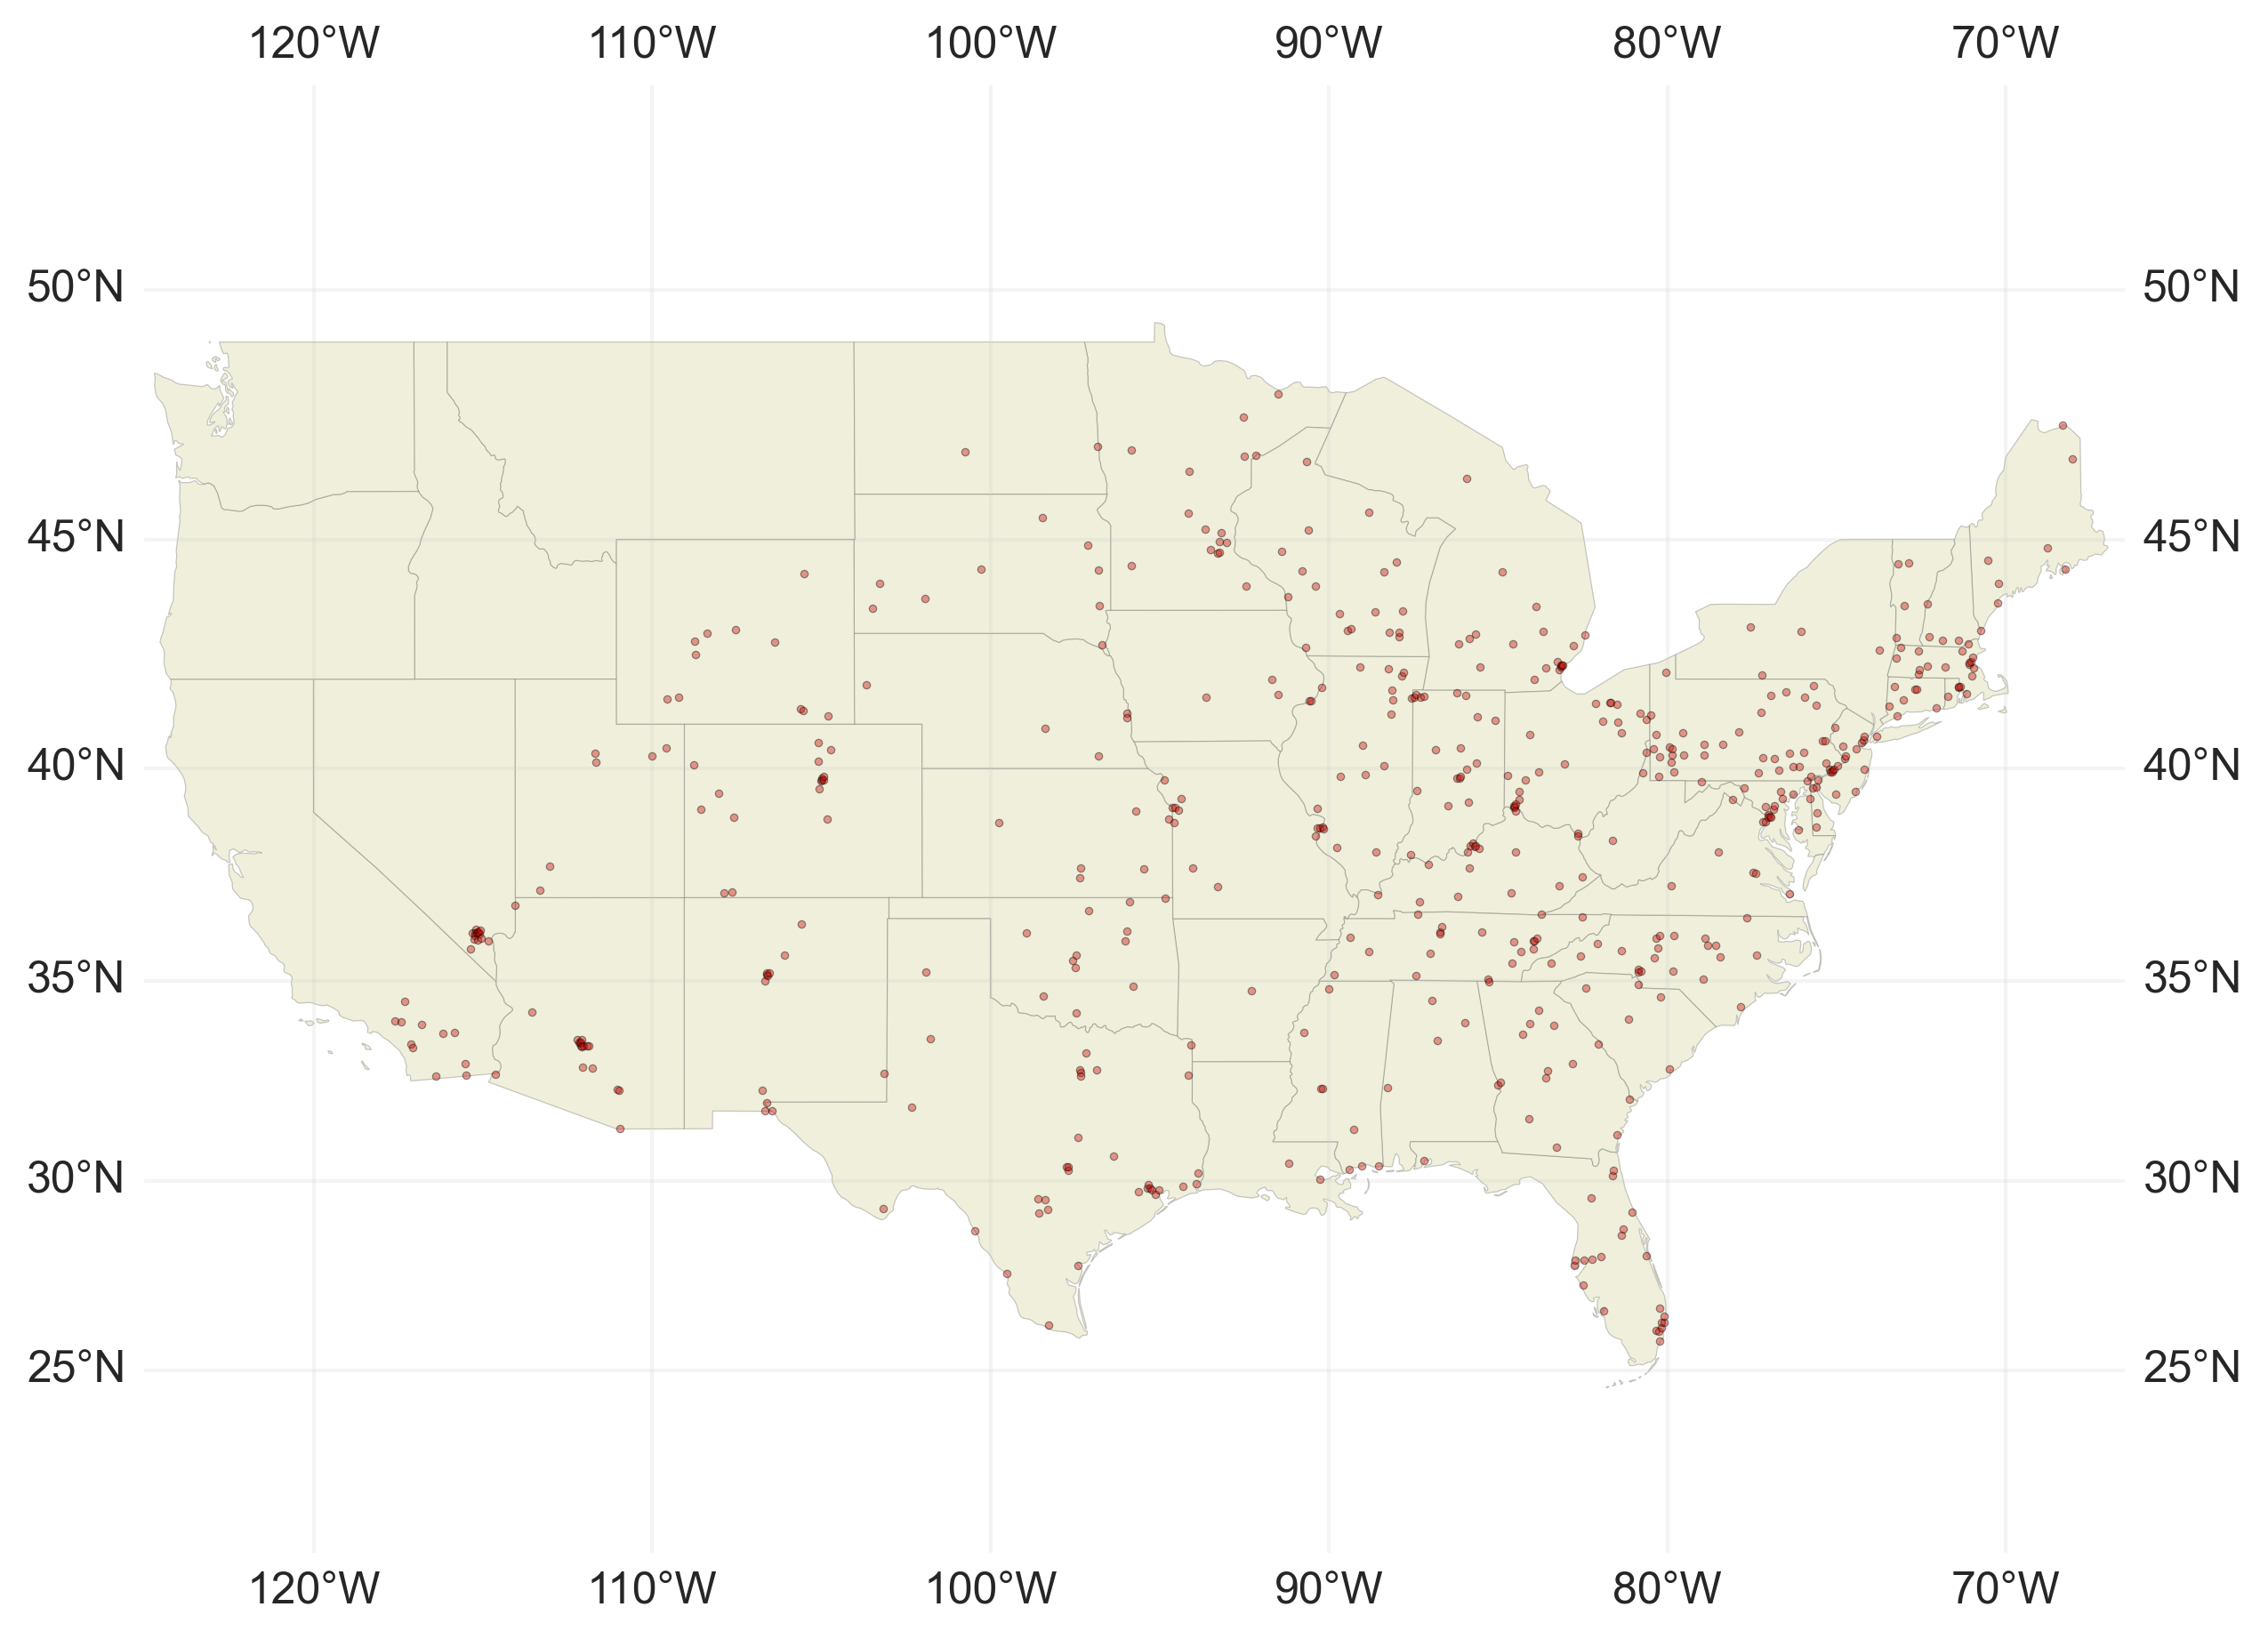

In [17]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

ax.add_geometries(
    contiguous_us.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state)


ax.scatter(lons, lats,
       s=4, 
       alpha=0.4, 
       c='r',
       edgecolor='black',
       transform=ccrs.PlateCarree(), 
       zorder=10);

# for i in us_locations.iterrows():
#     lon, lat, name = i[1].Longitude, i[1].Latitude, i[1]['Site Name']
#     ax.text(lon,
#             lat + 0.5,
#             name,
#             ha='center',
#             va='bottom',
#             transform=ccrs.PlateCarree(),
#             fontsize=4)

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)

In [18]:
from geopy.geocoders import Nominatim

In [19]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [20]:
texas_points = [p for p in pairs if texas.contains(p).item()]

In [21]:
places = {}
for p in texas_points:
    places[p.x, p.y] = geolocator.reverse(f'{p.y}, {p.x}')

In [22]:
houston = {}
for k, v in places.items():
    address = v.raw['address']
    if 'city' in address and address['city'] == 'Houston':
        print(v.address)
        houston[k] = v
#     if 'village' in address:
#         print(k, address['village'])
#     elif 'hamlet' in address:
#         print(k, address['hamlet'])
#     elif 'town' in address:
#         print(k, address['town'])
#     elif 'city' in address:
#         print(k, address['city'])
#     else:
#         print(k, v.address)

West Cavalcade Street, Houston, Harris County, Texas, 77009:77022, United States
7128, Kirkpatrick Boulevard, Houston, Harris County, Texas, 77028, United States
11085, Fleming Drive, Meadowood Estates, Houston, Harris County, Texas, 77013, United States


In [23]:
houston

{(-95.38061644353682,
  29.803966948989544): Location(West Cavalcade Street, Houston, Harris County, Texas, 77009:77022, United States, (29.803987777900193, -95.38061693555849, 0.0)),
 (-95.29186902522268,
  29.82392068787421): Location(7128, Kirkpatrick Boulevard, Houston, Harris County, Texas, 77028, United States, (29.823916975903614, -95.29185355823293, 0.0)),
 (-95.2332660275758,
  29.77665888146691): Location(11085, Fleming Drive, Meadowood Estates, Houston, Harris County, Texas, 77013, United States, (29.77634813375481, -95.23324984503516, 0.0))}

In [49]:
lons, lats = list(map(list, zip(*houston.keys())))

In [114]:
from shapely.geometry import Polygon
world = gpd.GeoSeries([Polygon([(-180,-90), (-180,90), (180, 90), (180, -90)])], crs=texas.crs)
world = gpd.GeoDataFrame({'geometry': world})
all_but_texas = world.symmetric_difference(texas.reset_index())

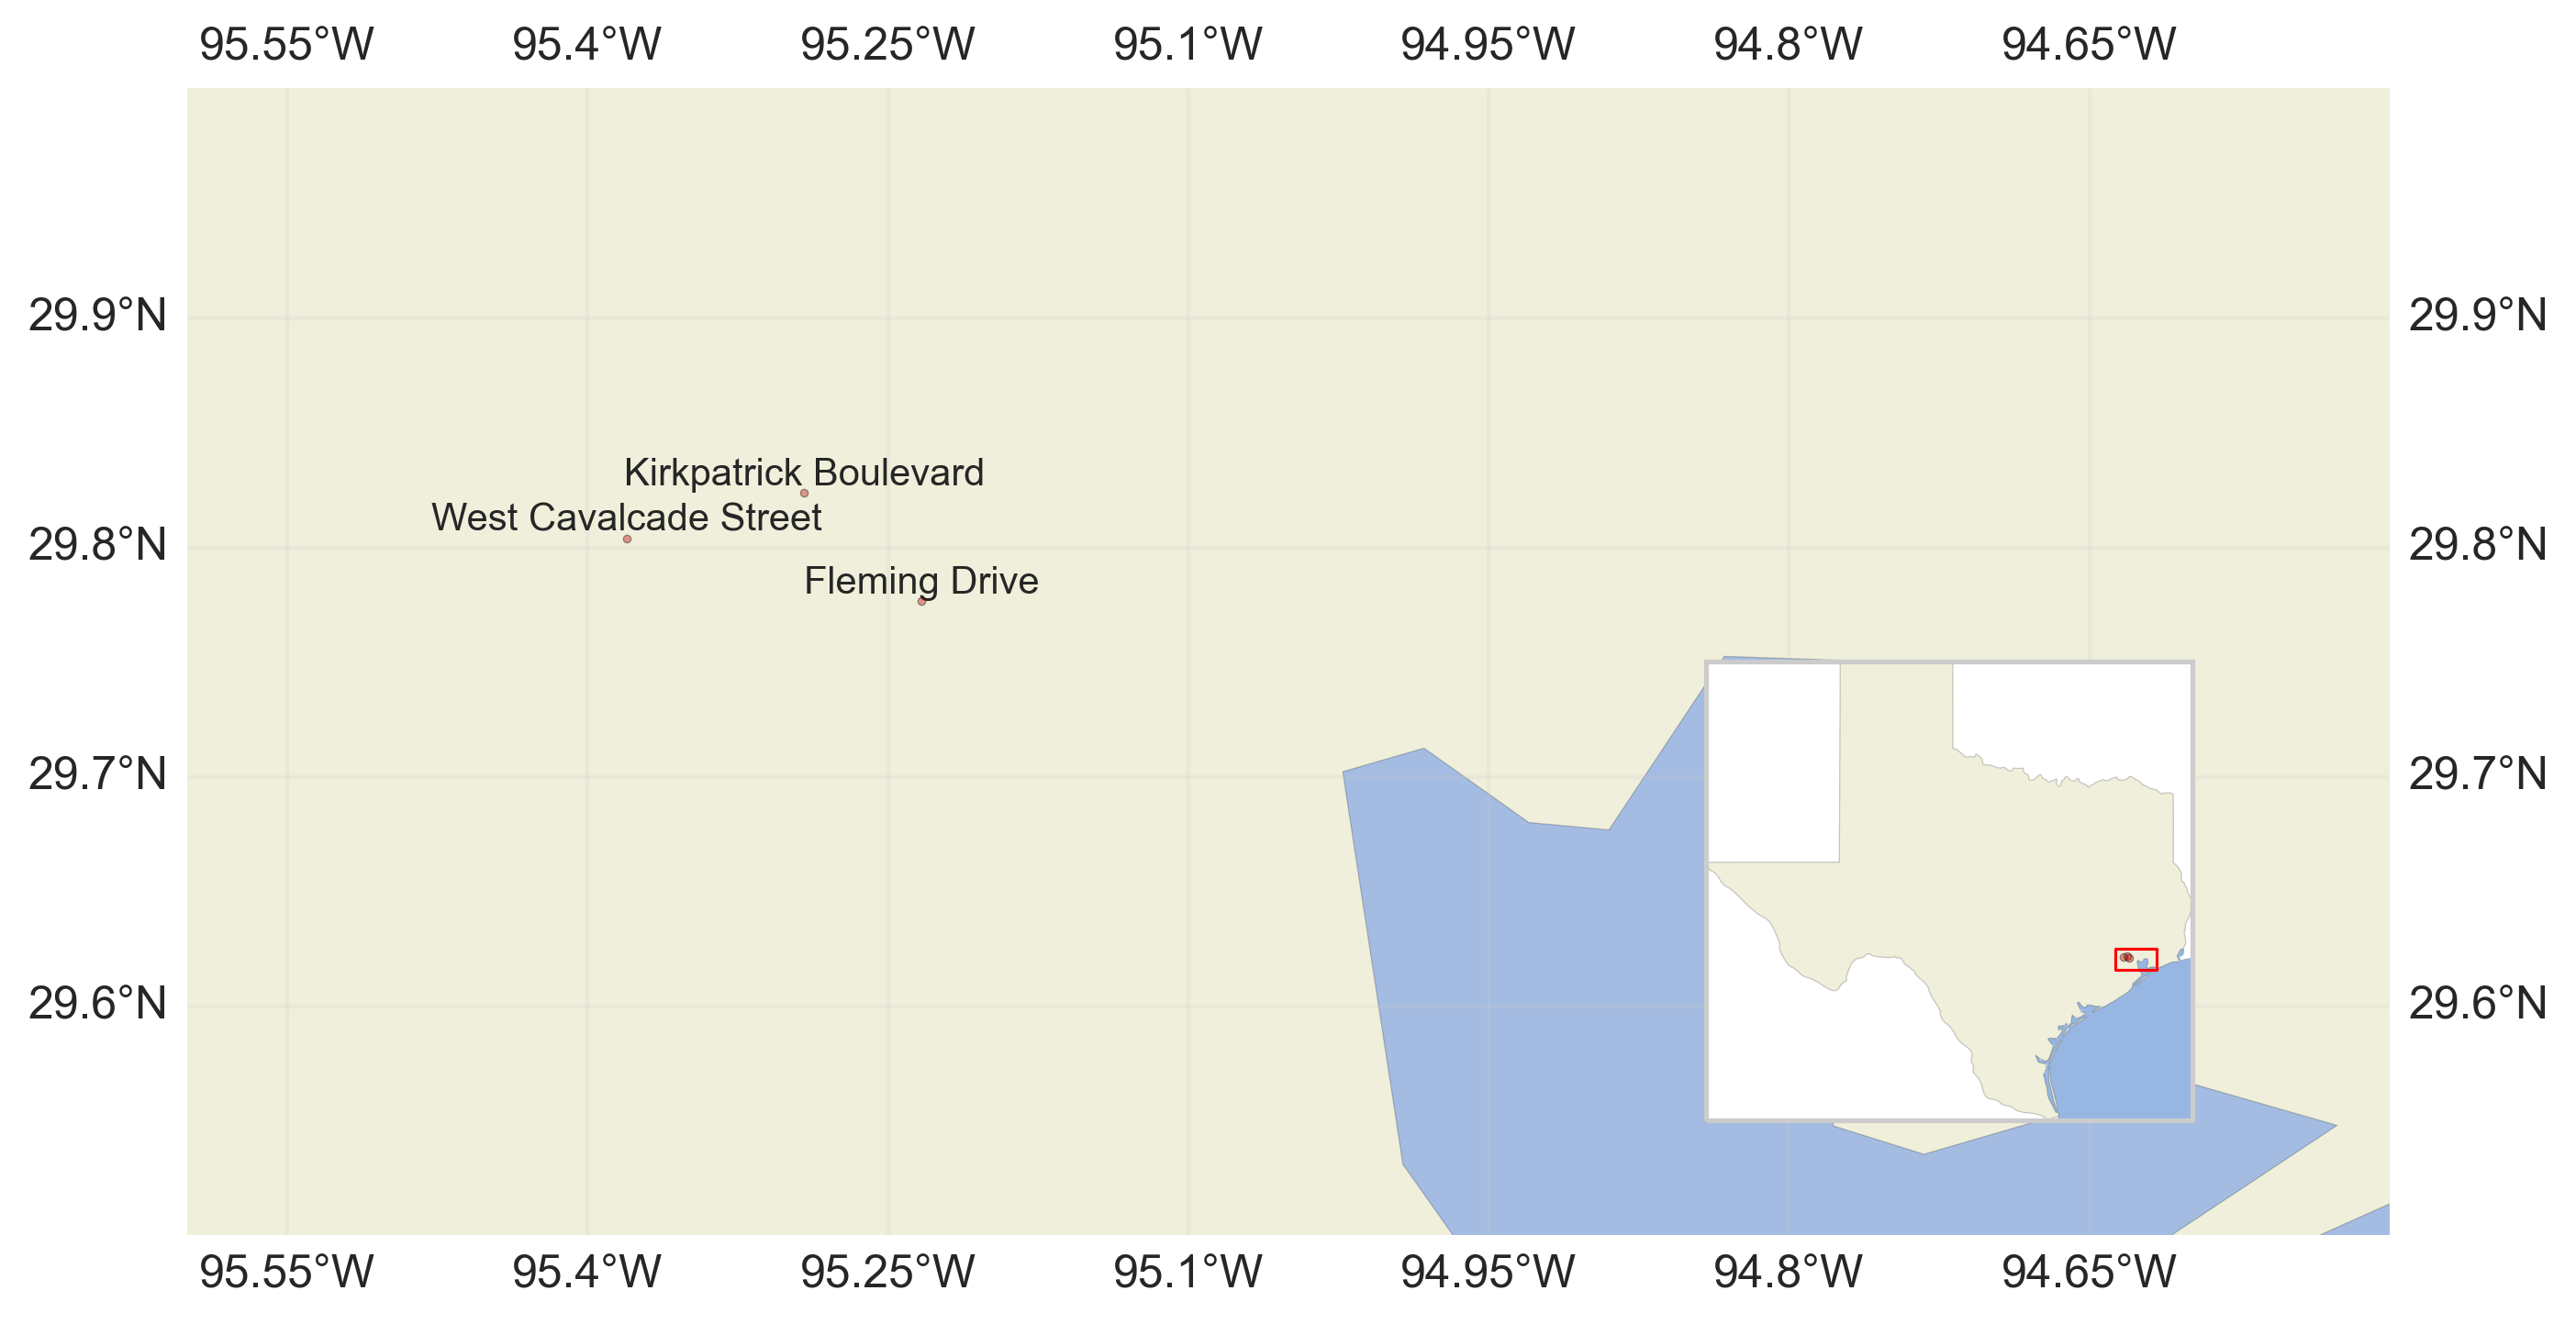

In [126]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from shapely.geometry.polygon import LinearRing

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

def colorize_ocean(geometry):
    return {'facecolor': '#86A6DA33', 'edgecolor': '#86A6DA33'}

fig = plt.figure(dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)

ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Mercator())
ax2.add_geometries(
    texas.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state)

inset_x = .8
inset_y = .3
inset_size = 0.4
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)

ax.add_geometries(
    all_but_texas.geometry,
    ccrs.PlateCarree(),
    styler=colorize_ocean)

ax.add_geometries(
    texas.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state)

ax.scatter(lons, lats,
       s=4, 
       alpha=0.4, 
       c='r',
       edgecolor='black',
       transform=ccrs.PlateCarree(), 
       zorder=10);

ax2.scatter(lons, lats,
       s=4, 
       alpha=0.4, 
       c='r',
       edgecolor='black',
       transform=ccrs.PlateCarree(), 
       zorder=10);

for (lon, lat), v in houston.items():
    ax.text(lon, lat+.0005,
        f"{v.raw['address']['road']}",
        ha='center',
        va='bottom',
        transform=ccrs.PlateCarree(),
        fontsize=10)

inset_lonmin, inset_lonmax, inset_latmin, inset_latmax = -95.6, -94.5, 29.5, 30
nvert = 100
ring_lons = np.r_[np.linspace(inset_lonmin, inset_lonmin, nvert),
             np.linspace(inset_lonmin, inset_lonmax, nvert),
             np.linspace(inset_lonmax, inset_lonmax, nvert)].tolist()
ring_lats = np.r_[np.linspace(inset_latmin, inset_latmax, nvert),
             np.linspace(inset_latmax, inset_latmax, nvert),
             np.linspace(inset_latmax, inset_latmin, nvert)].tolist()

ring = LinearRing(list(zip(ring_lons, ring_lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)
    
ax.set_extent([inset_lonmin, inset_lonmax, inset_latmin, inset_latmax], plate)
ax2.set_extent([minlon, maxlon, minlat, maxlat], plate)

# ax.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.OCEAN)

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)

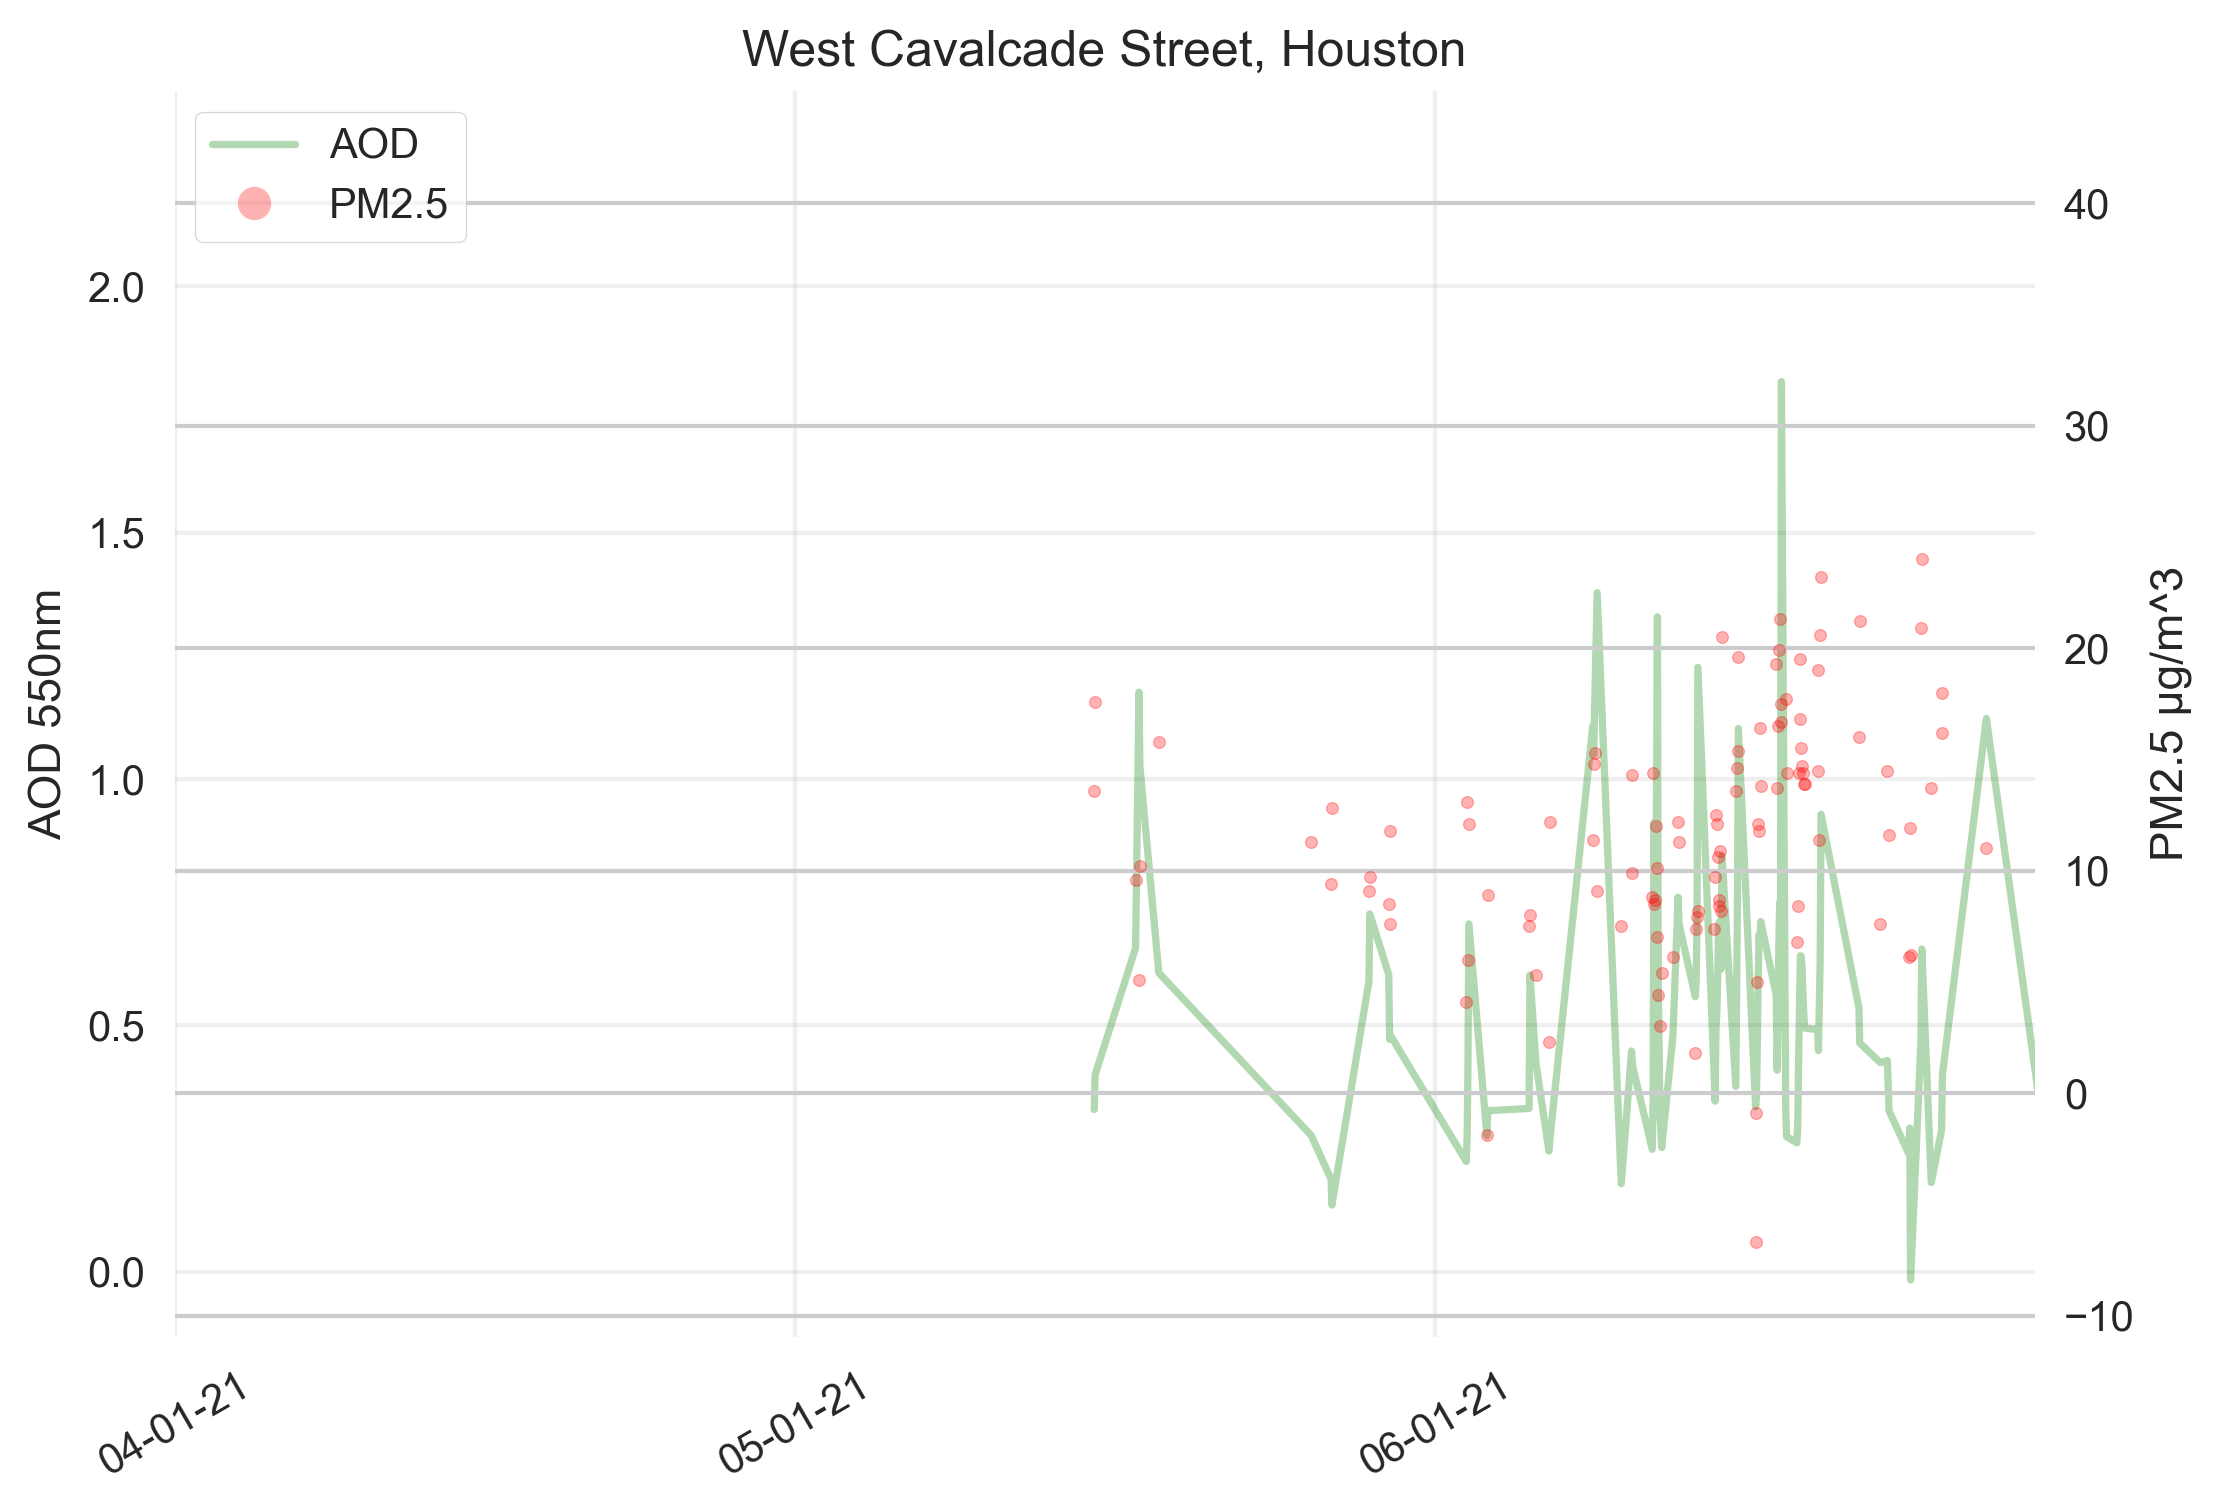

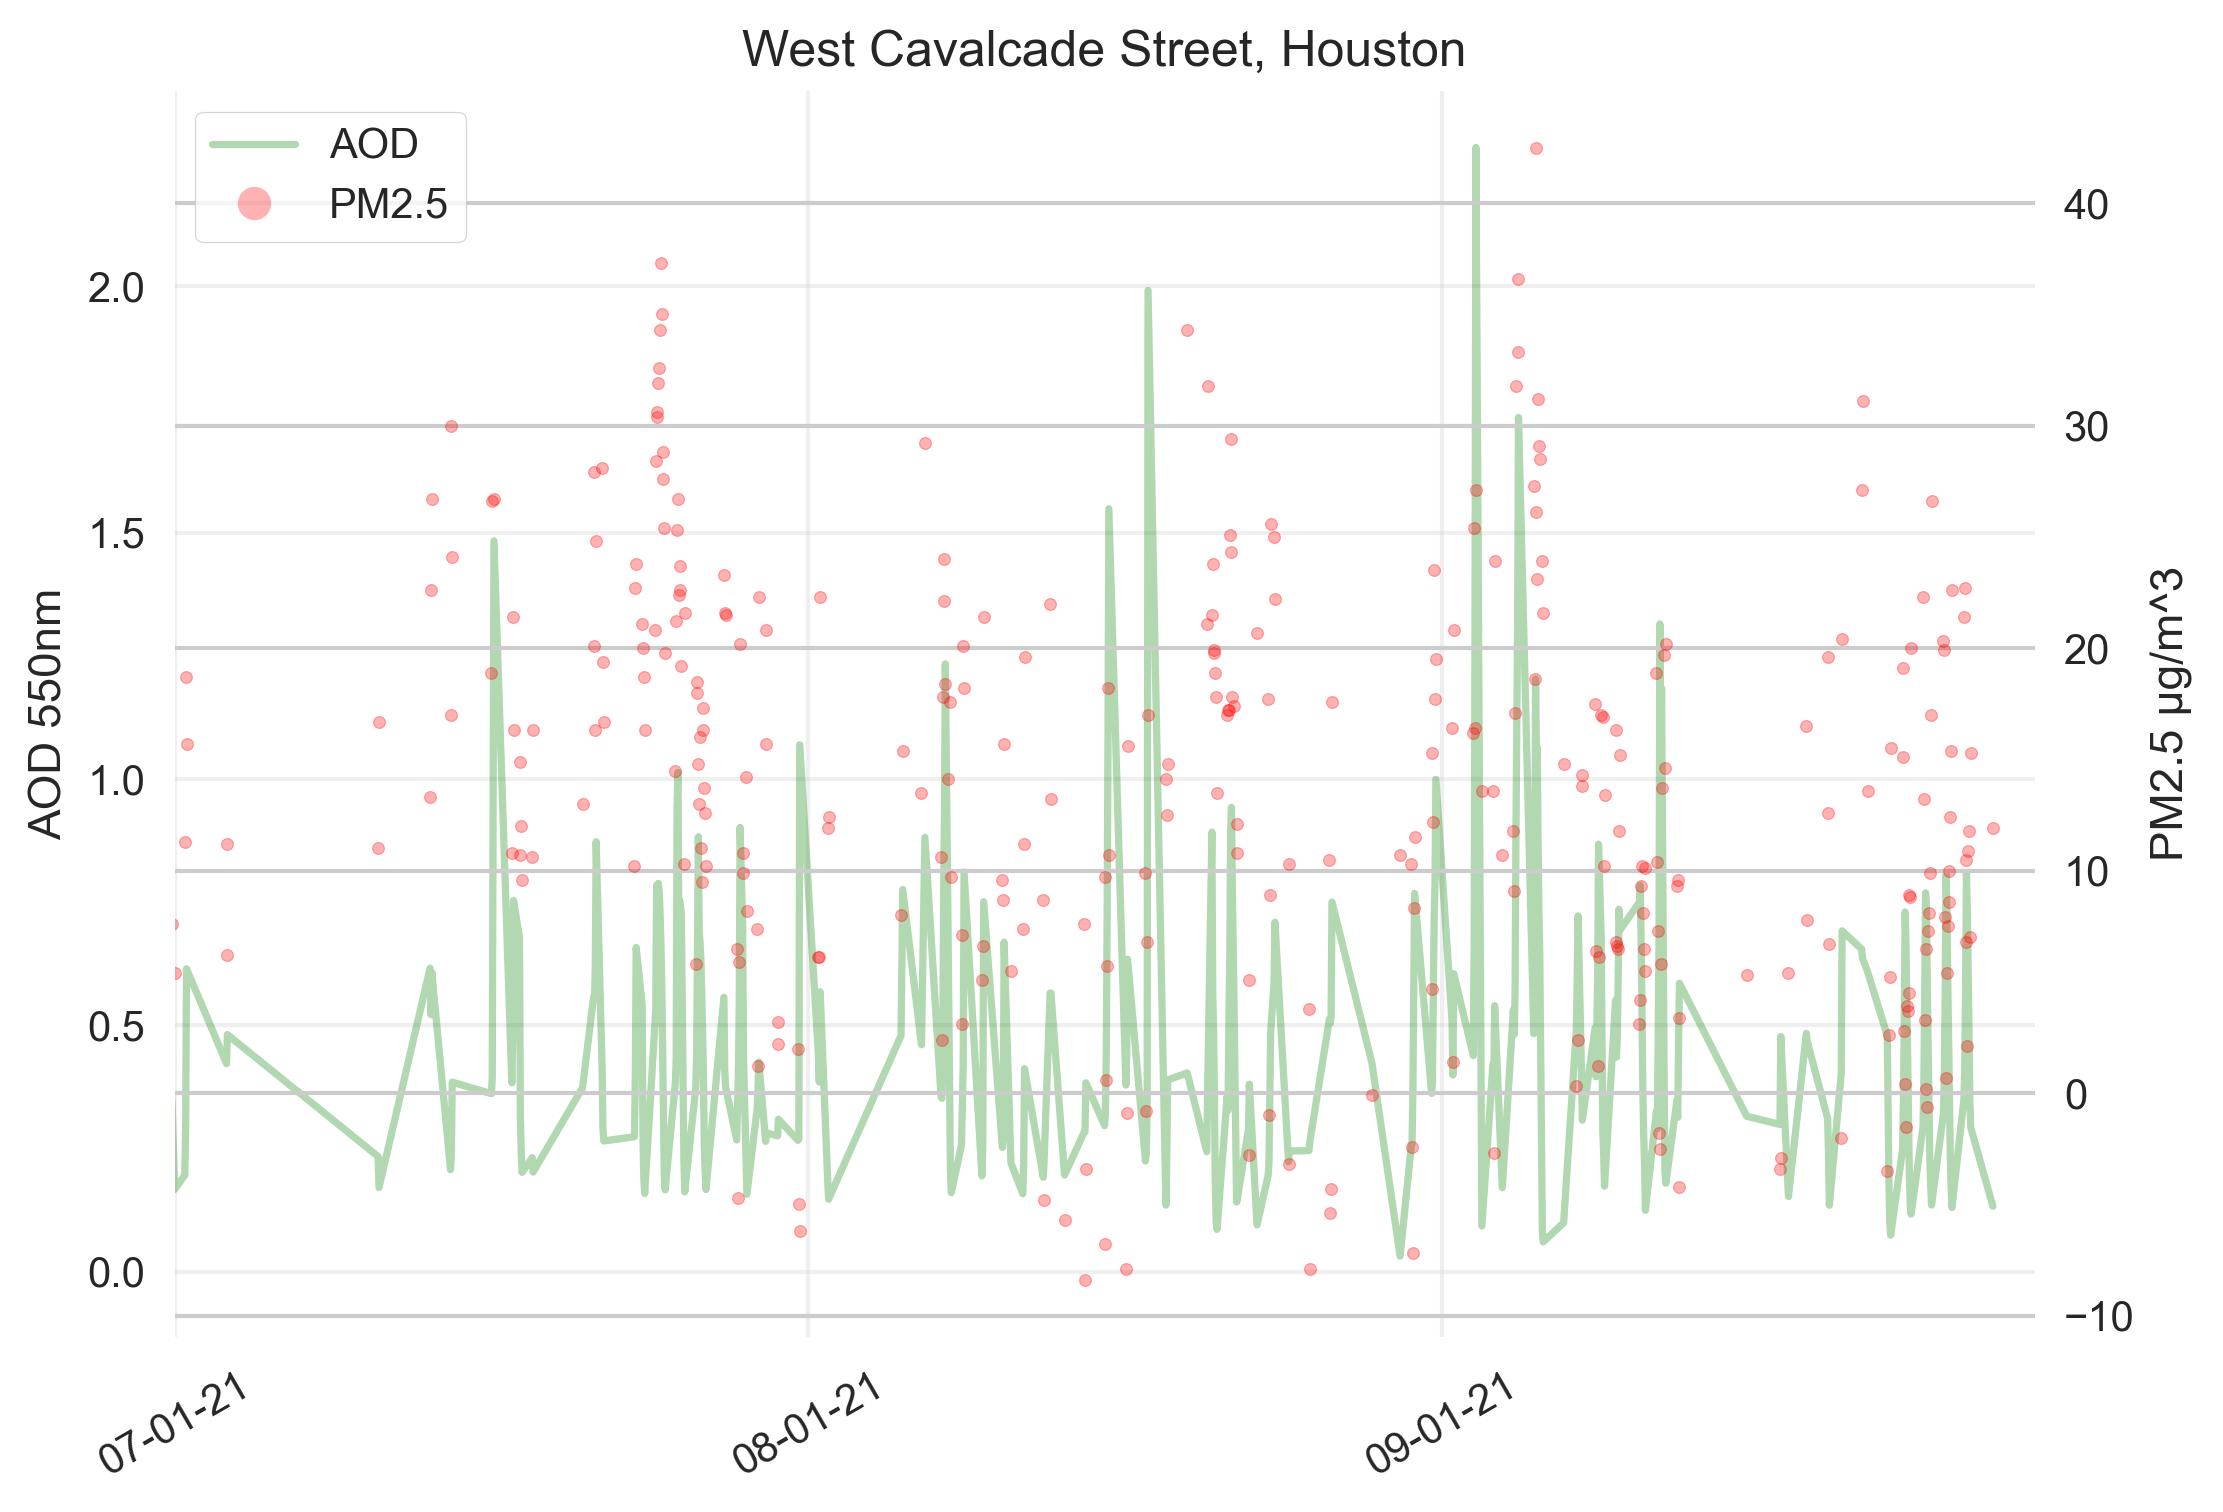

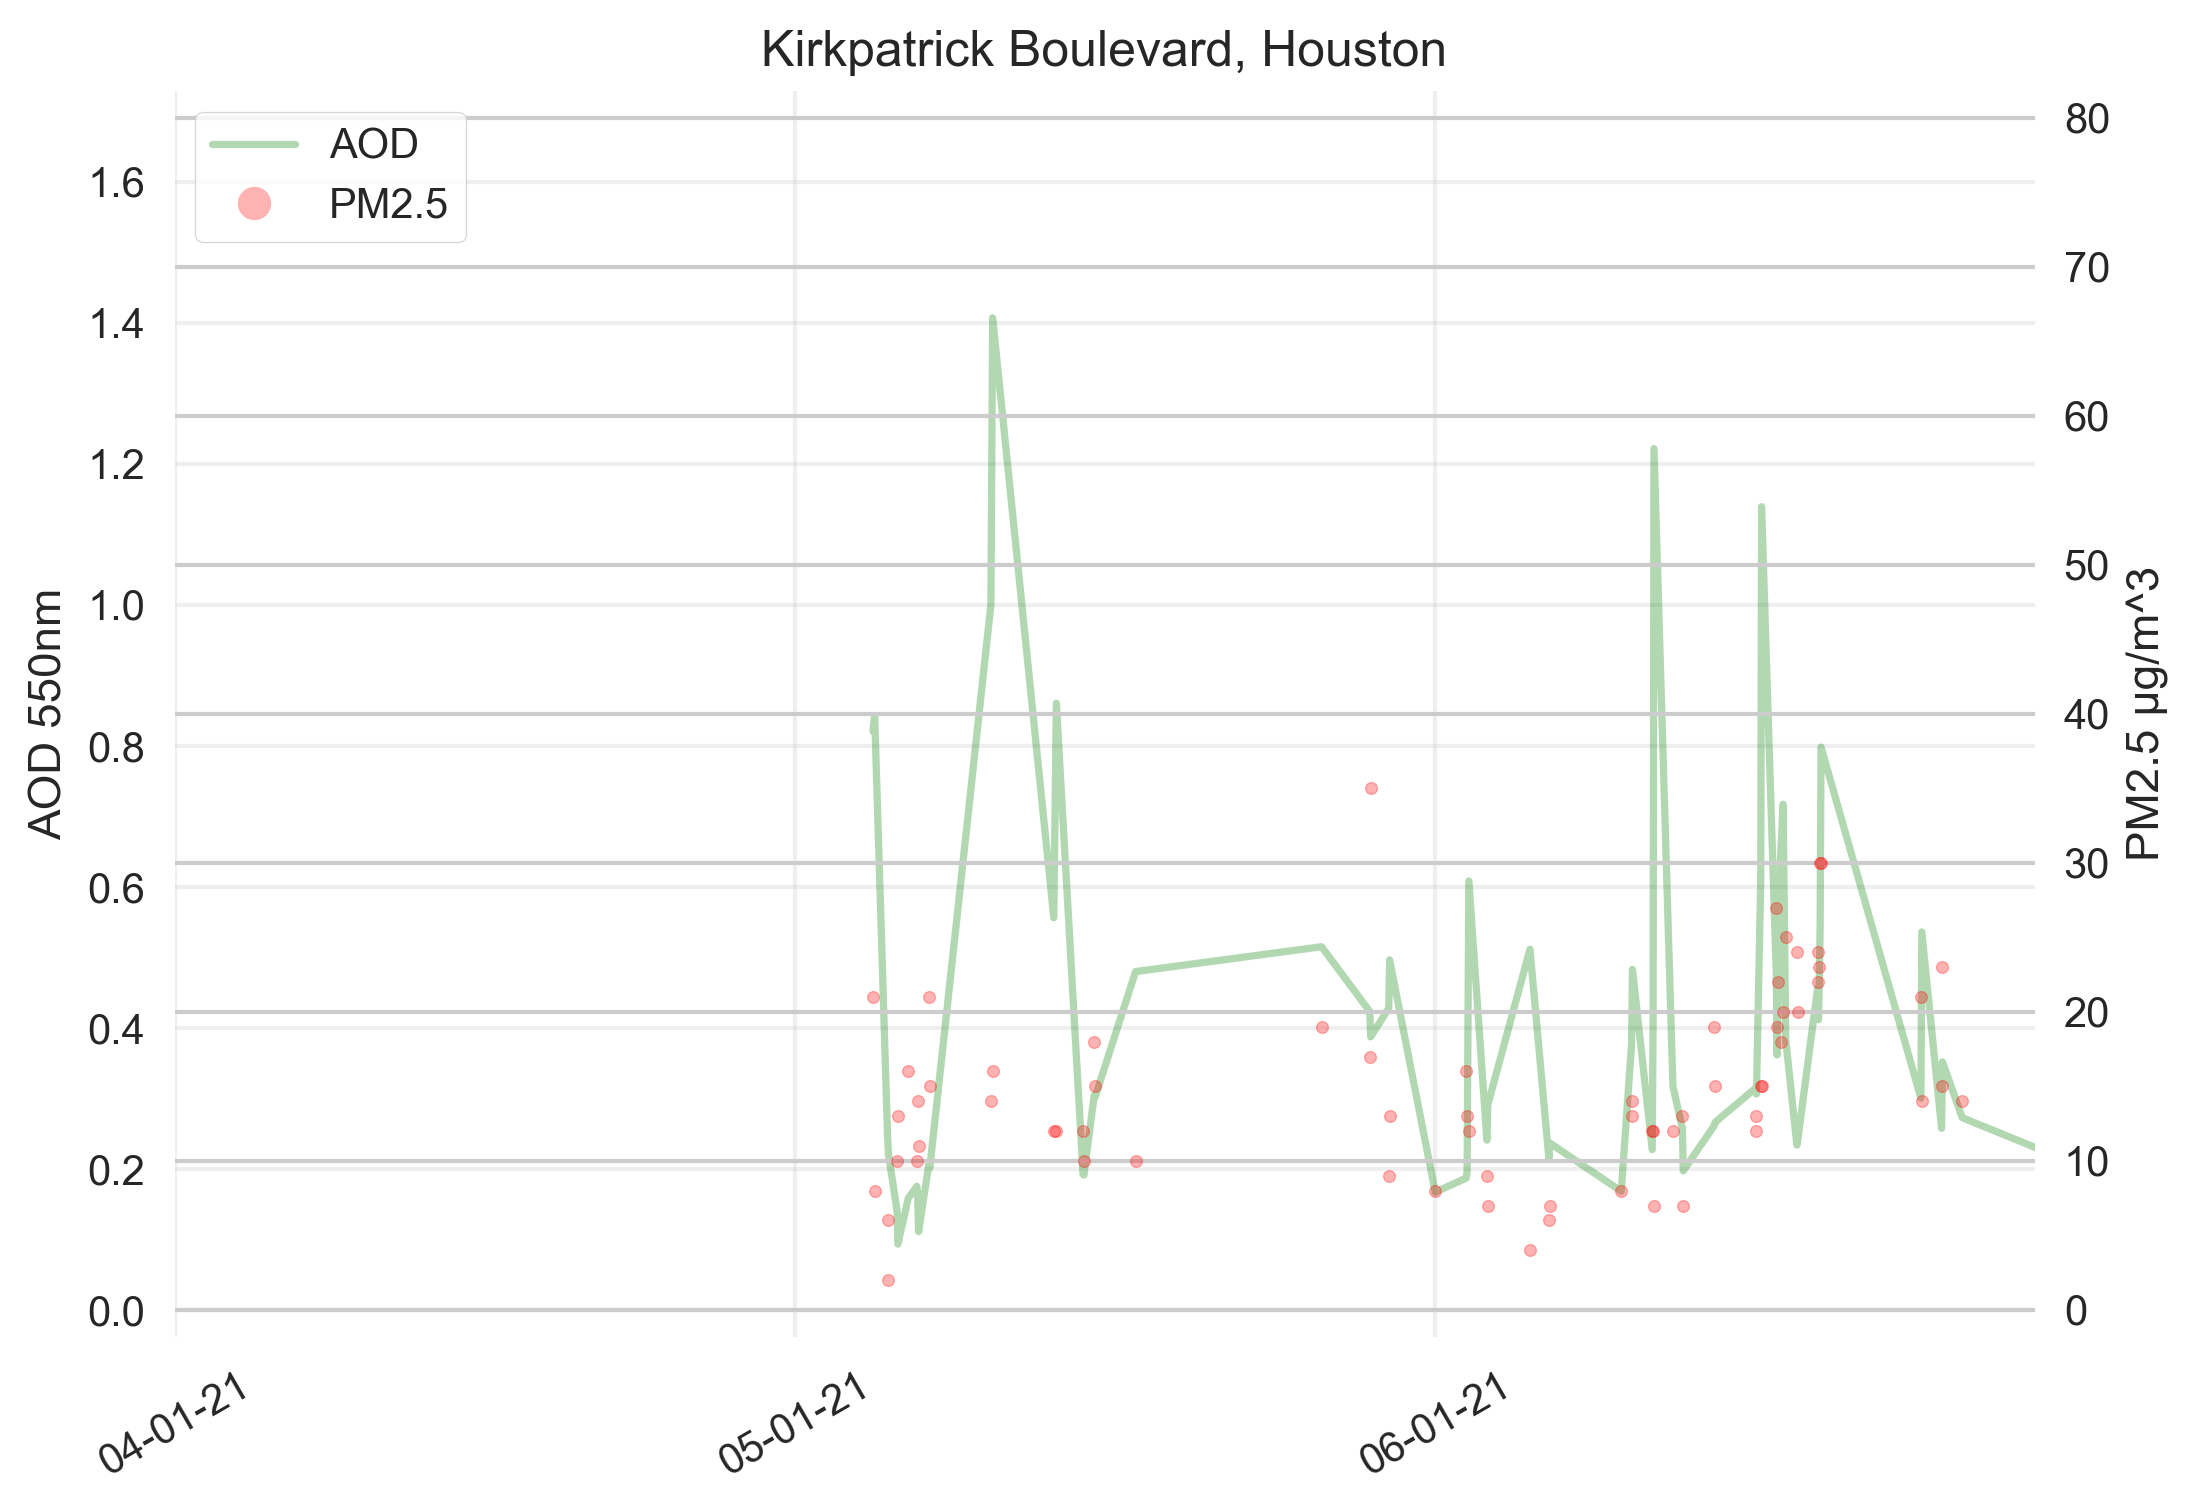

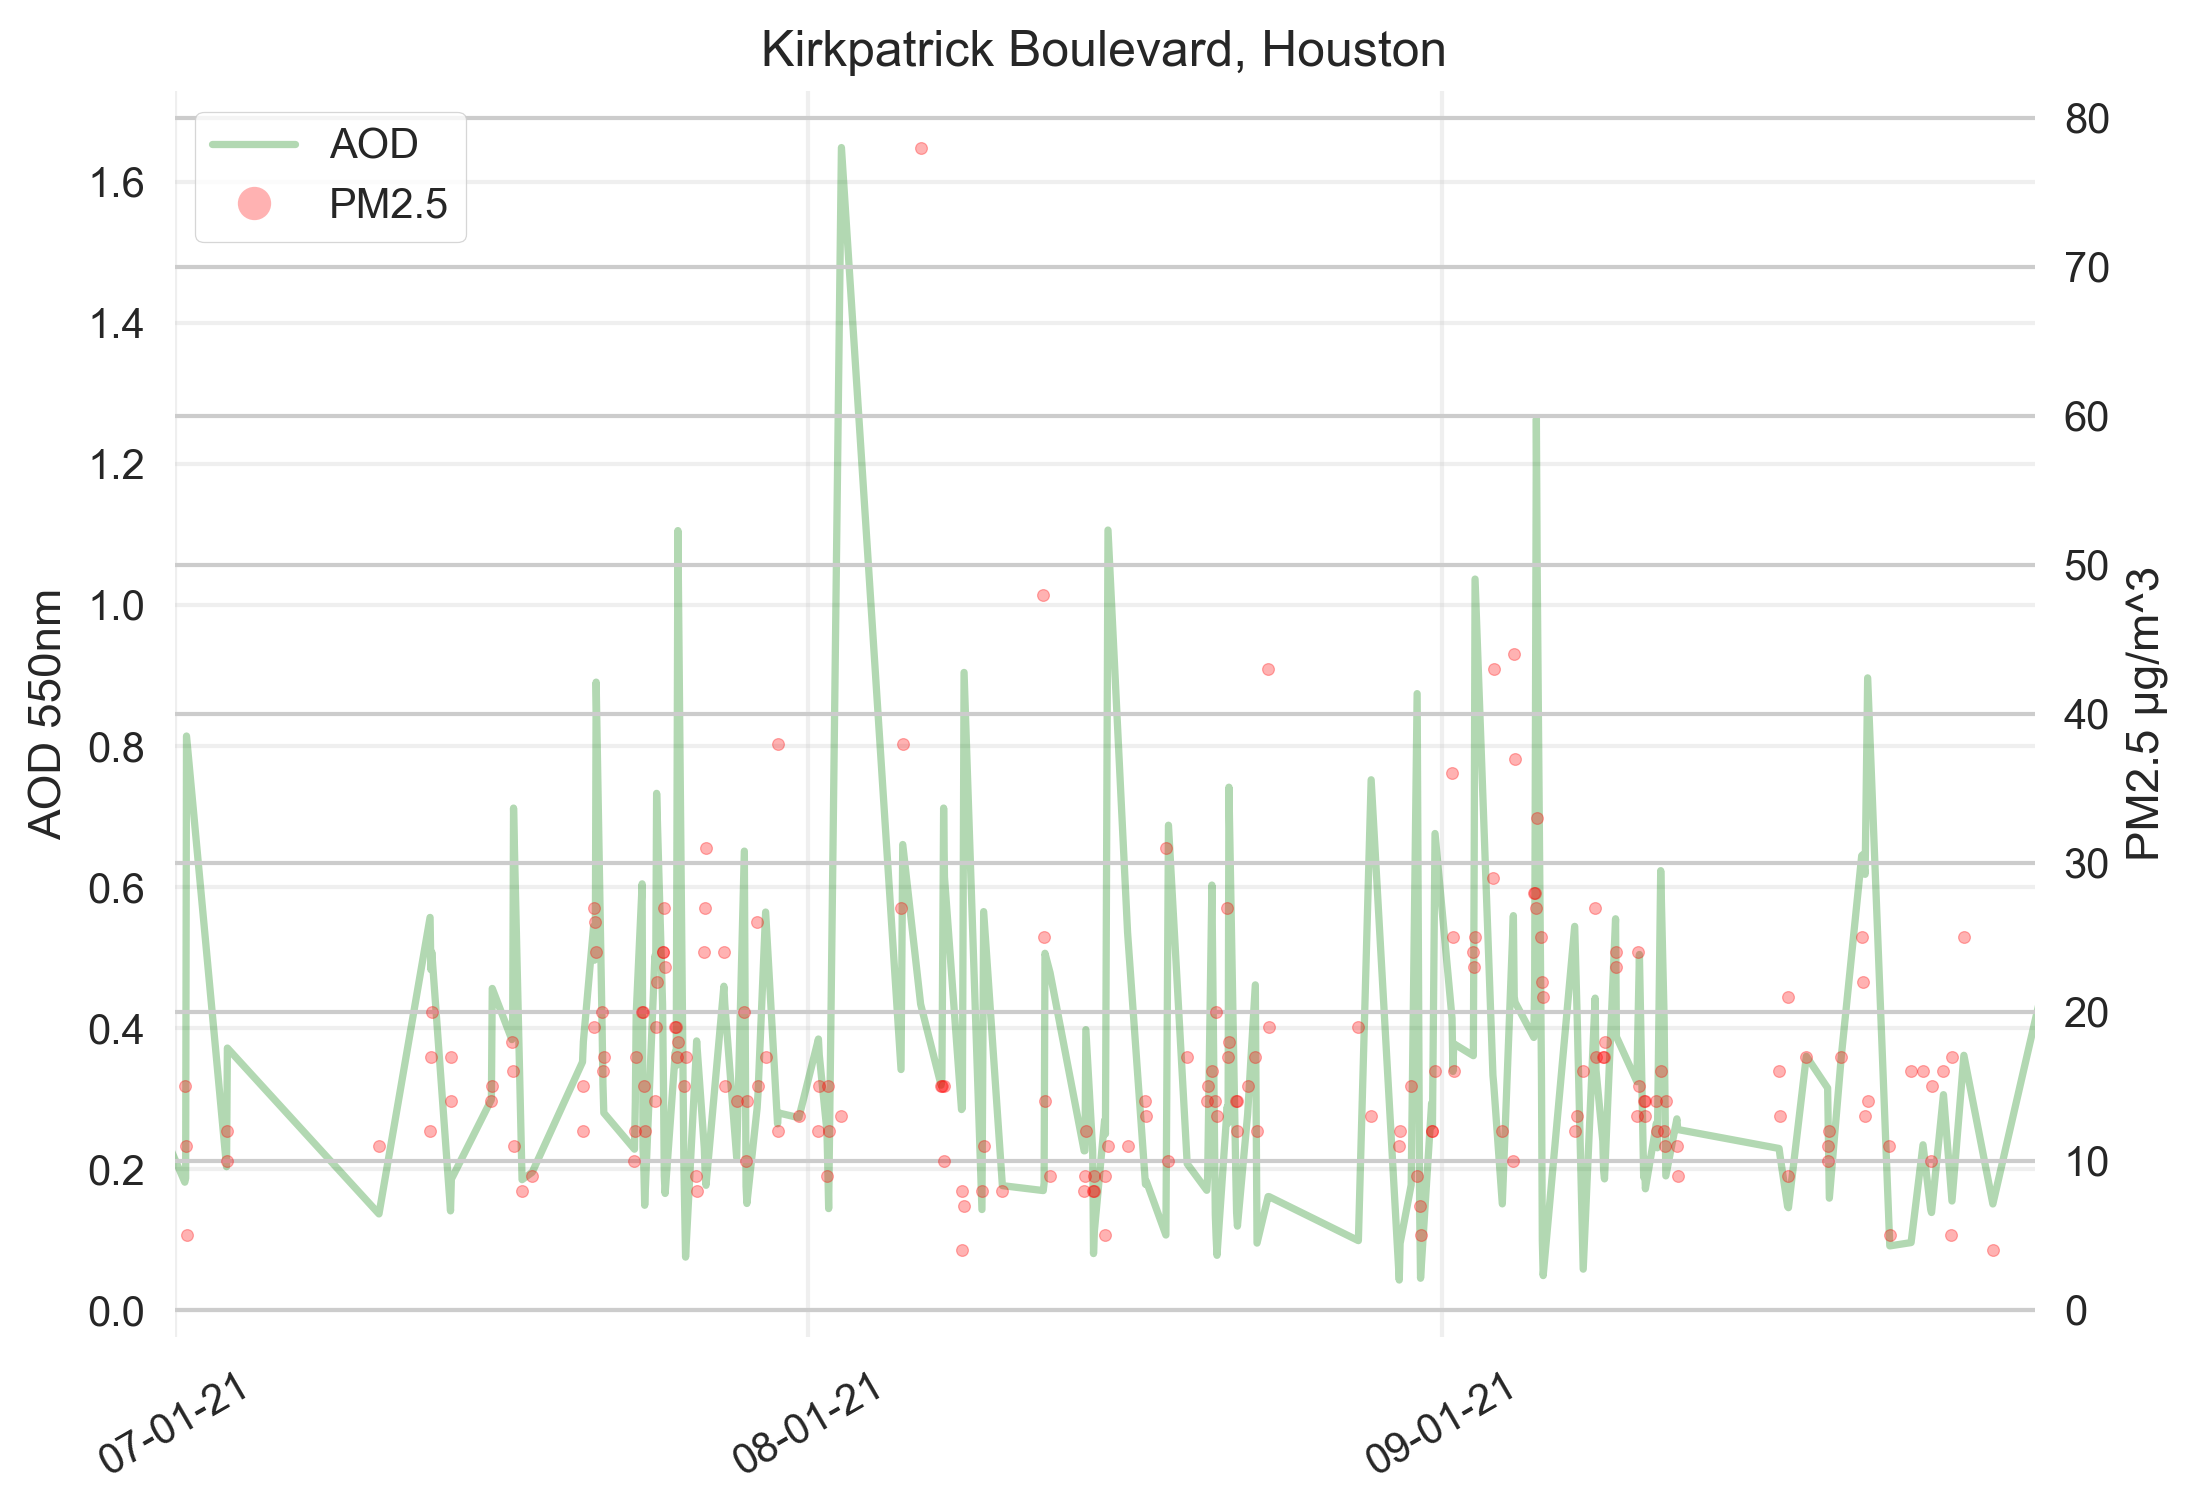

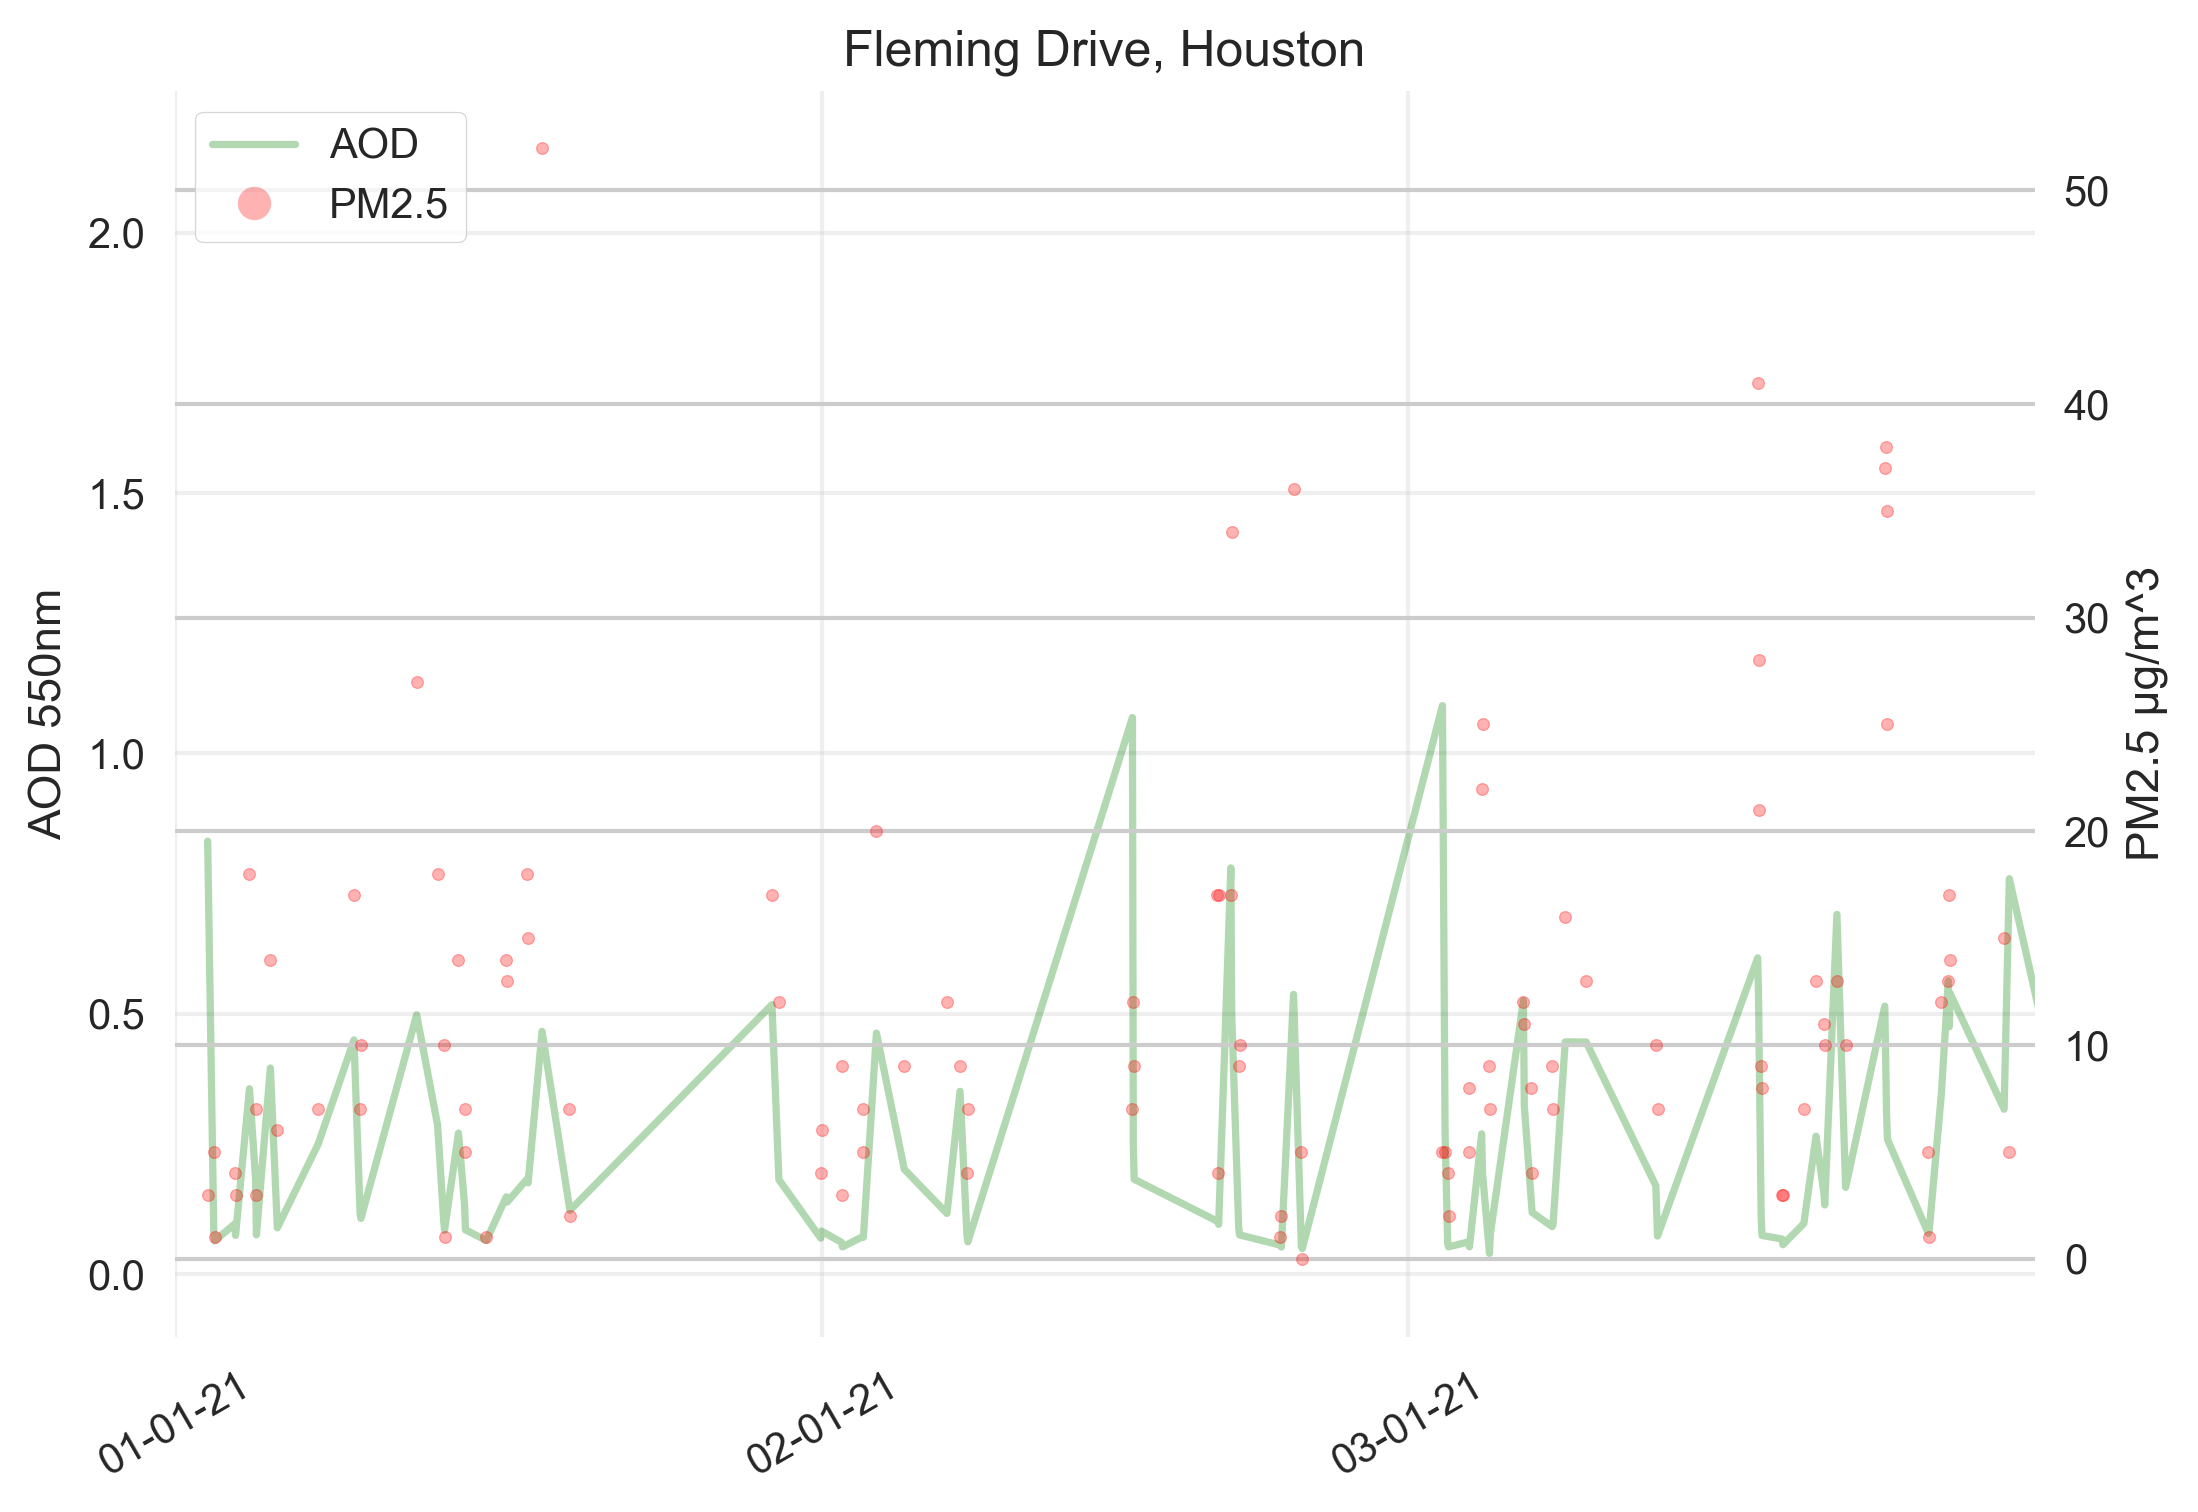

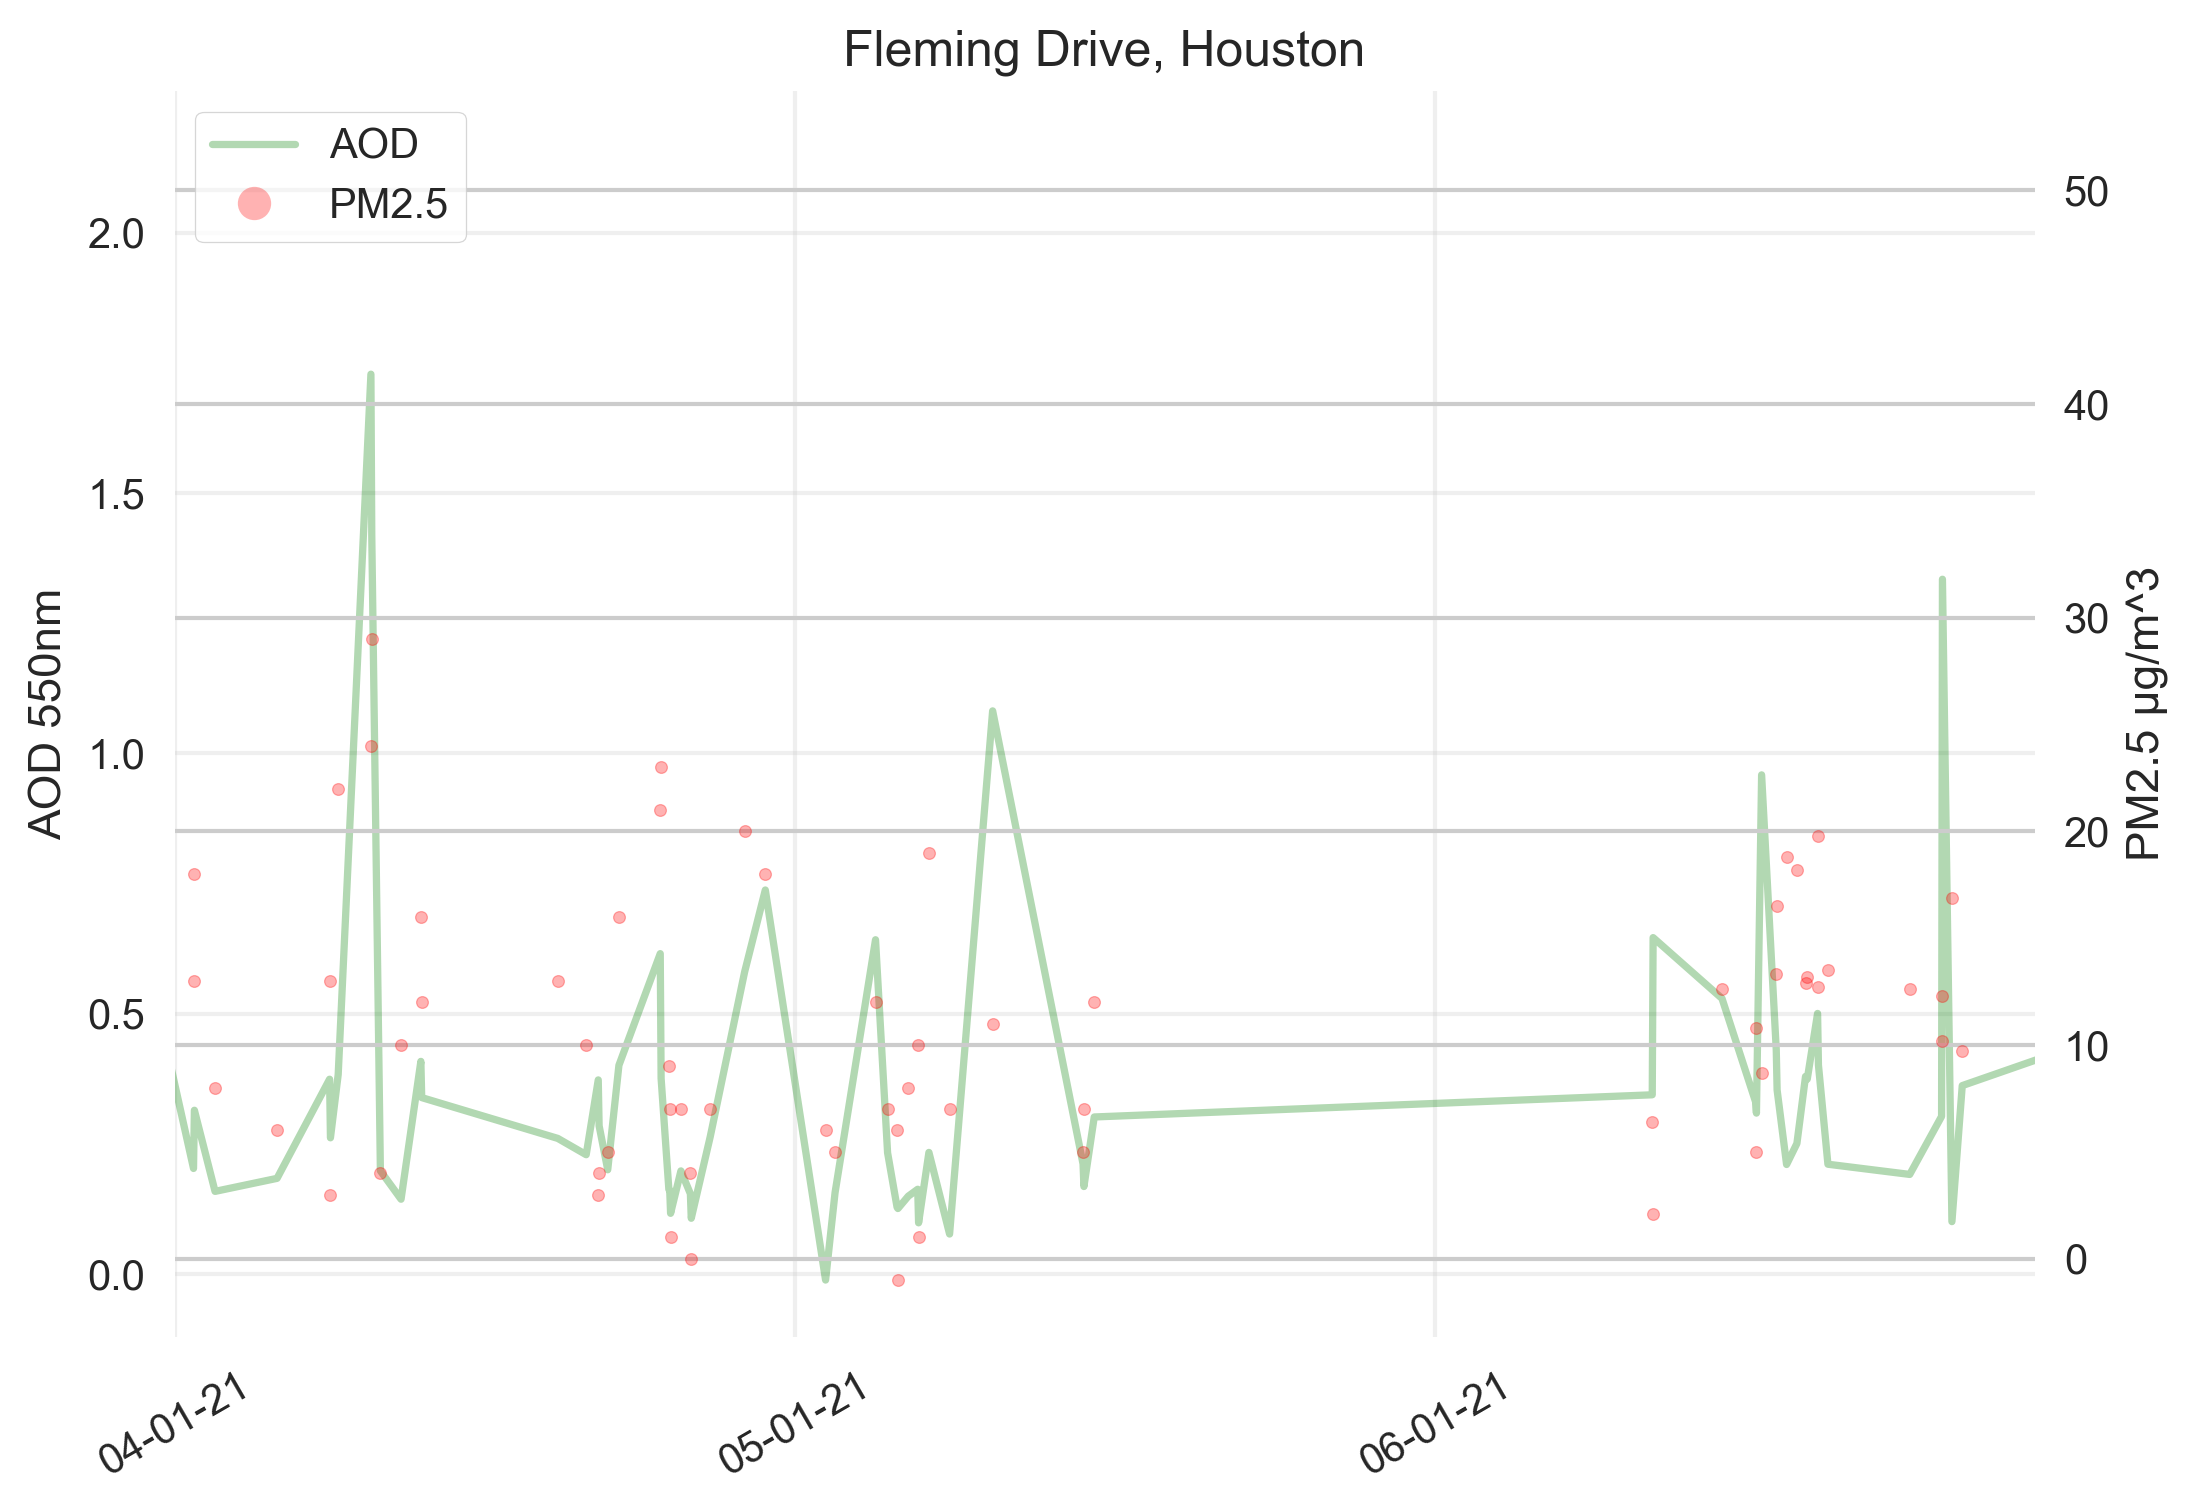

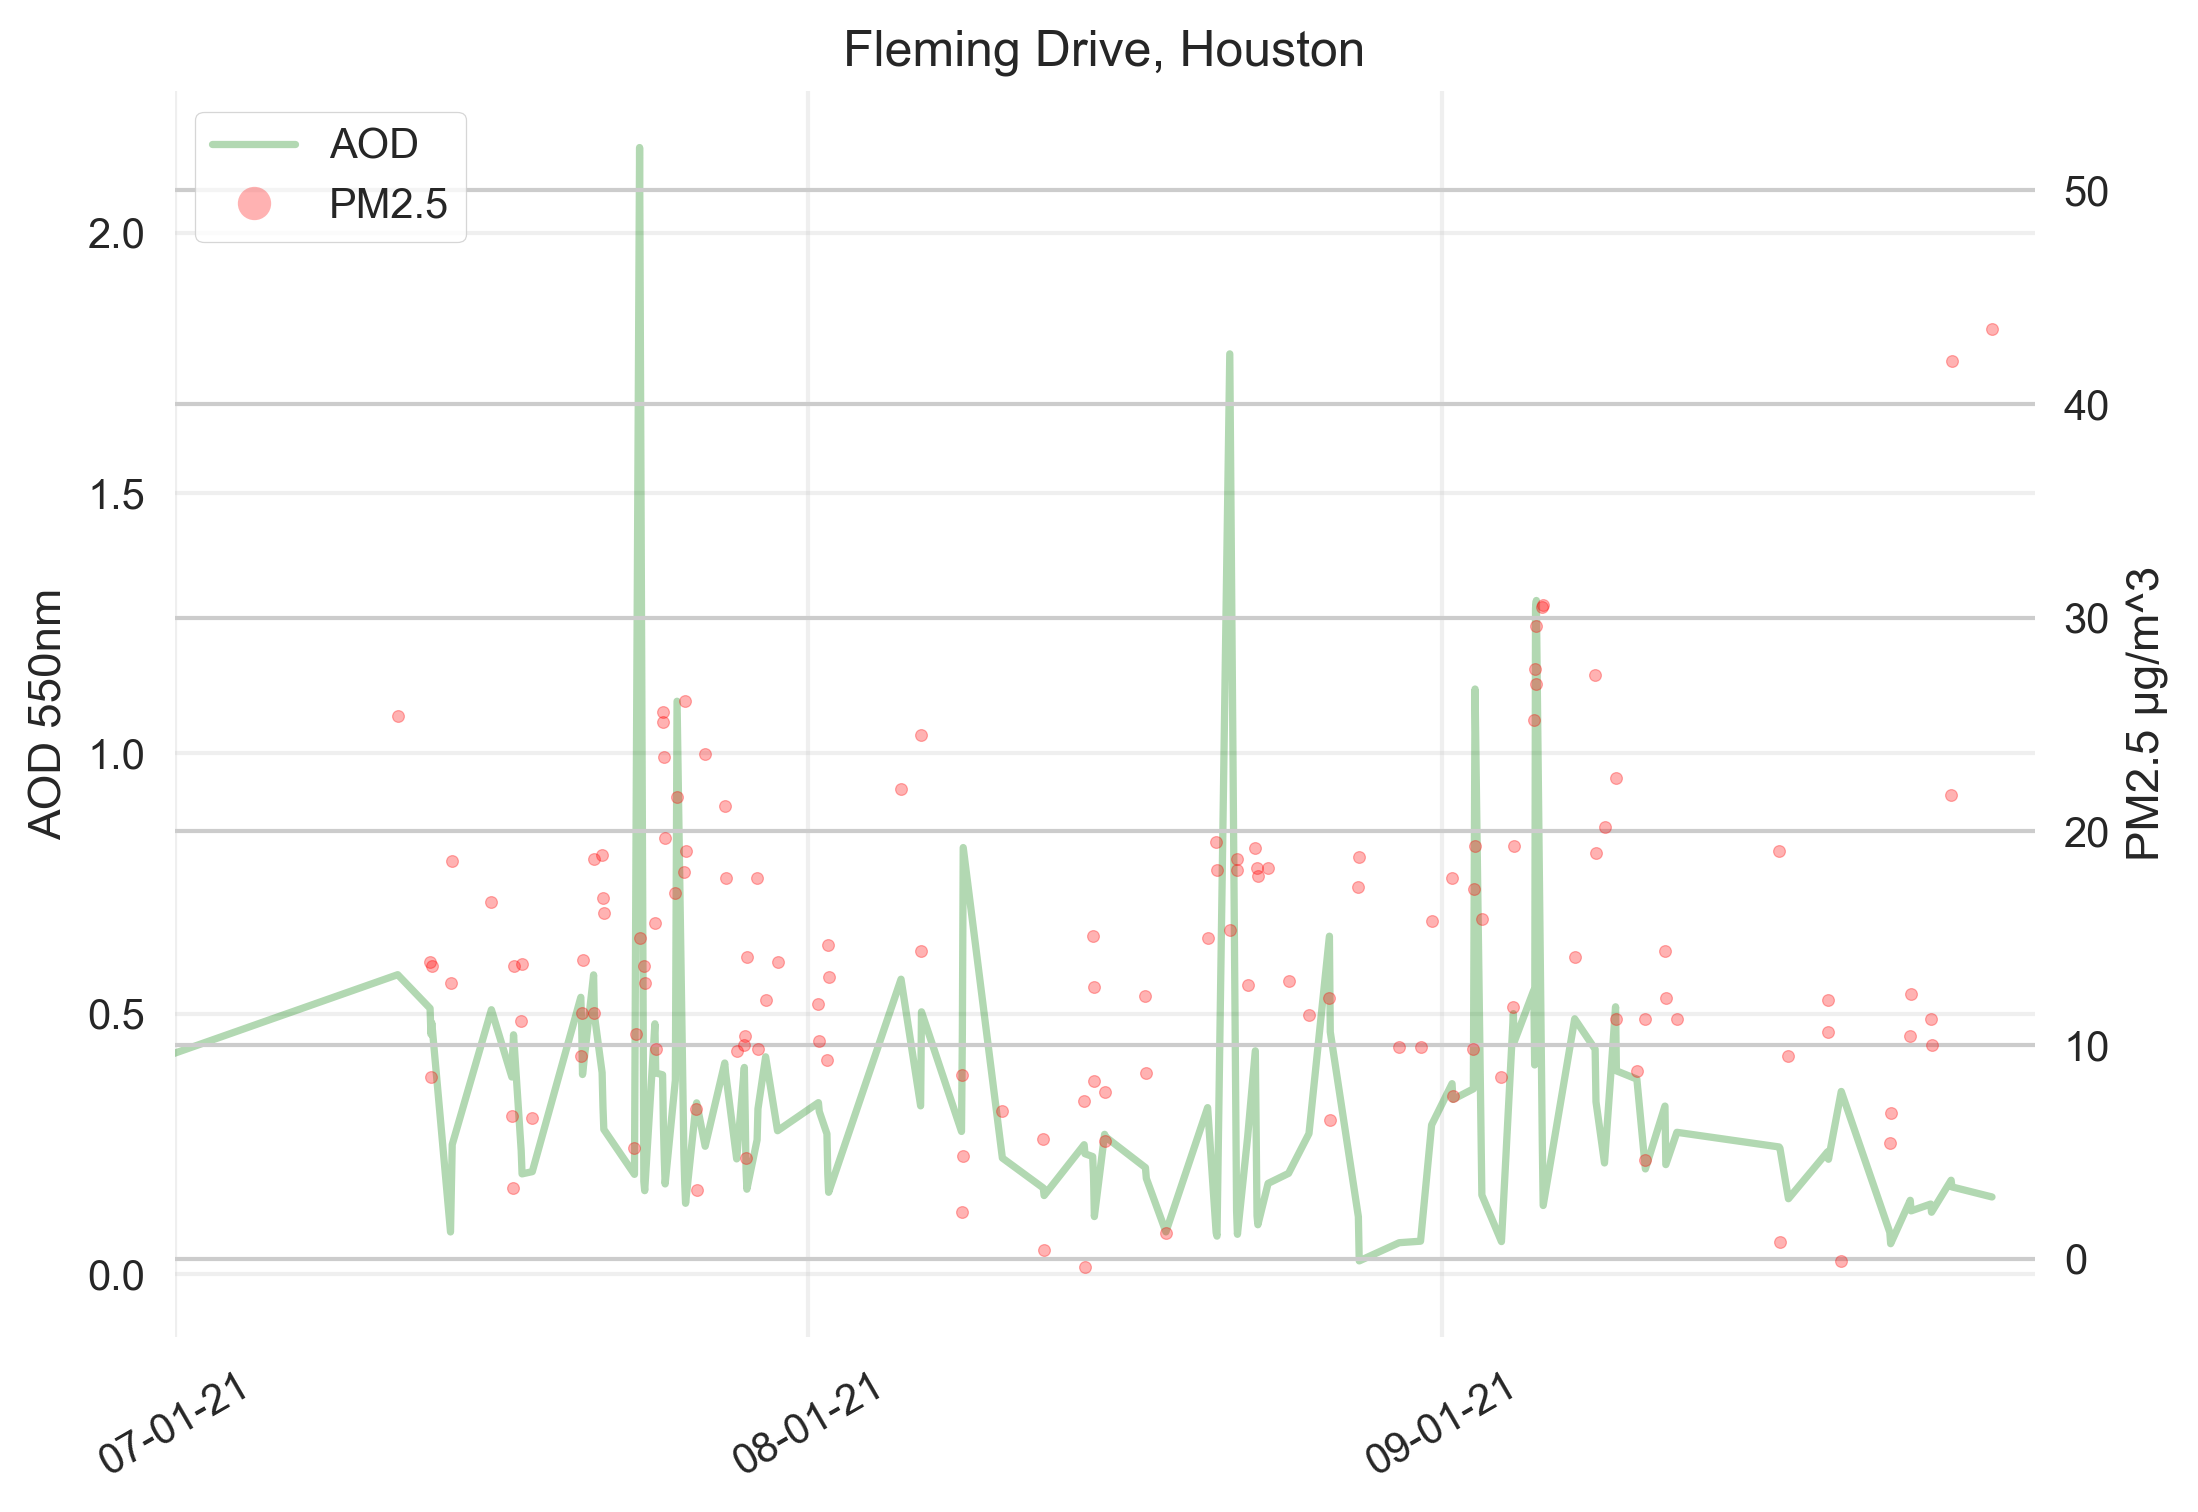

In [128]:
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

for (lon, lat), v in houston.items():
    data = df.where((df.latitude==lat) & (df.longitude==lon)).dropna()
#     data = data.set_index('time').resample('1h').first().reset_index()
    title = f"{v.raw['address']['road']}, {v.raw['address']['city']}"
    
    for xlim in map(pd.to_datetime, [
        ('2021-01-01', '2021-03-31'),
        ('2021-04-01', '2021-06-30'),
        ('2021-07-01', '2021-09-30'),
        ('2021-10-01', '2021-12-13')
    ]):
        if not np.any(data.where((data.time > xlim[0]) & (data.time < xlim[1]))):
            continue
        fig, ax = plt.subplots(dpi=300)

        ax.set_title(title)
        ax2 = ax.twinx()

        alpha=0.3
        lw=1
        ms=8
        ax.plot(data.time, data.AOD, color='green', alpha=alpha)
        ax2.scatter(data.time, data['PM2.5'], color='red', alpha=alpha, s=ms)

    #     ax.set_ylim(-.2, 3)
    #     ax2.set_ylim(-2, 5)
        ax.set_ylabel('AOD 550nm')
        ax2.set_ylabel('PM2.5 µg/m^3')
        ax.set_xlim(xlim)

        custom_lines = [Line2D([], [], color='green', alpha=alpha),
                        Line2D([], [], marker='o', color='red', alpha=alpha, linestyle='None', markersize=ms)]

        ax2.legend(custom_lines, ['AOD', 'PM2.5'], loc='upper left', frameon=True, markerscale=1)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.tick_params(axis='x', rotation=30)
        ax.tick_params(axis='both', width=0)
        ax.grid(alpha=0.3)

        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(False)
            ax2.spines[spine].set_visible(False)


In [7]:
df = df[df['PM2.5'] > 0]

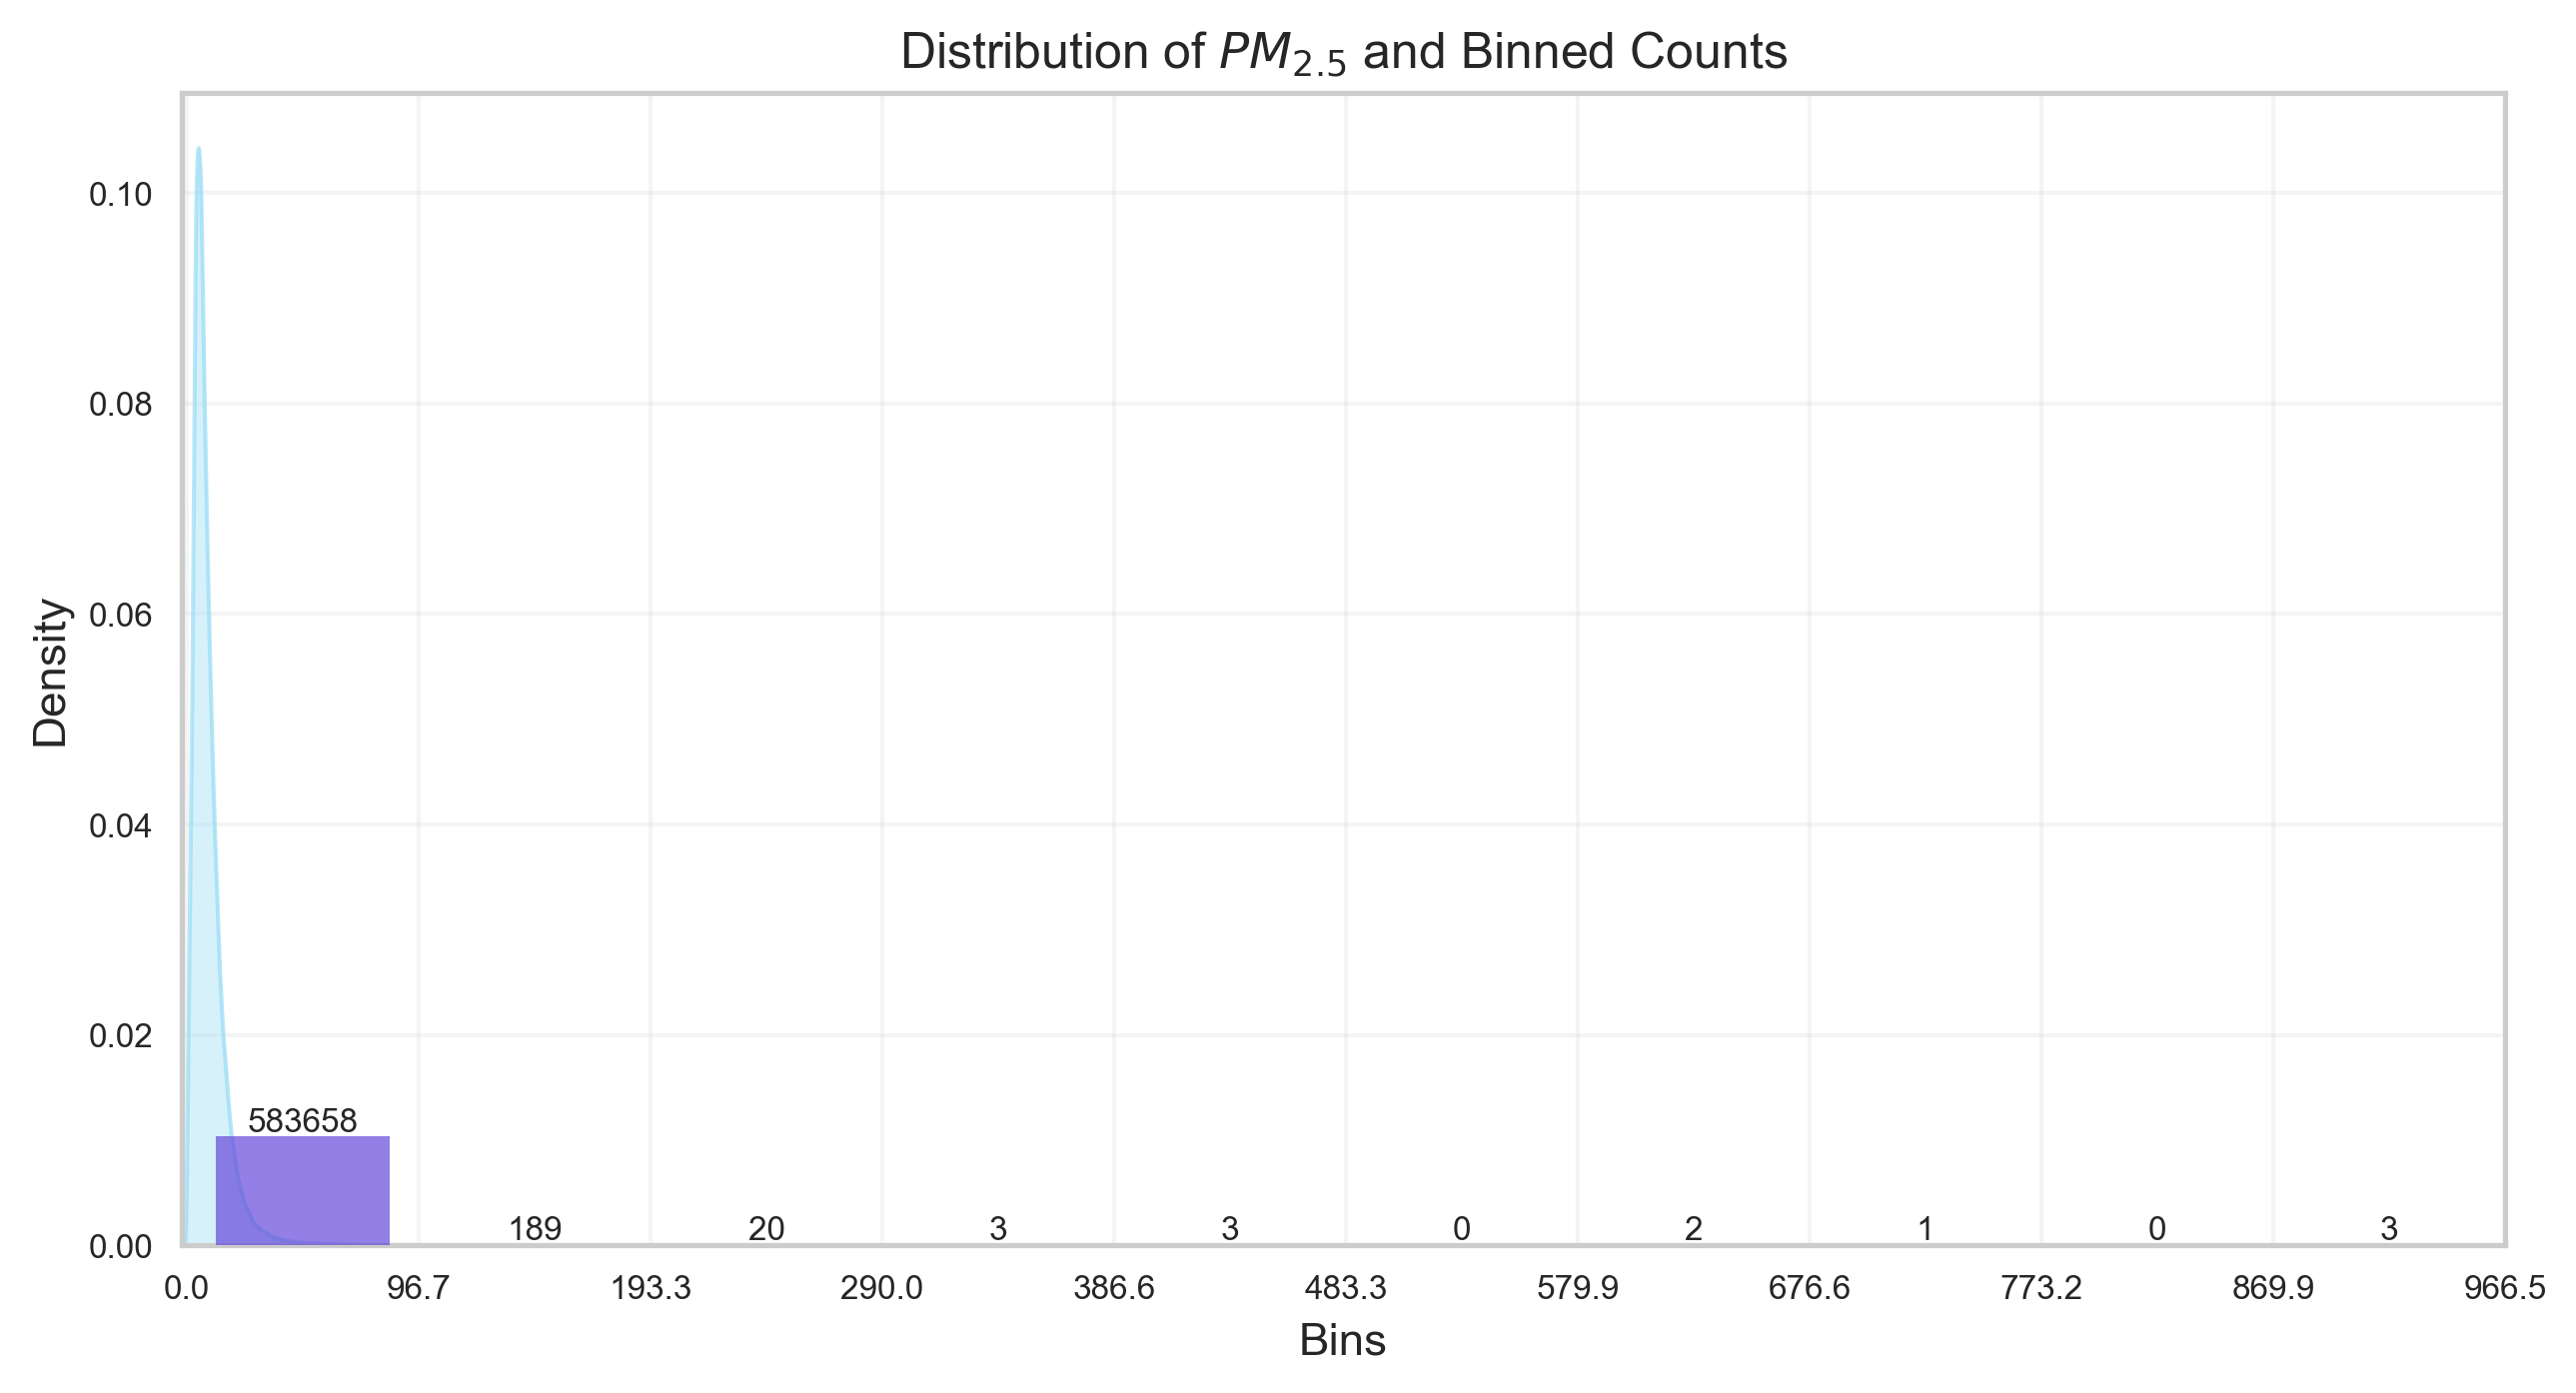

In [28]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-2, 
                       ax=ax)

# plt.savefig(os.path.join(paths.figures, 'distribution.png'))

In [8]:
df['PM2.5'] = df['PM2.5'].apply(np.log)

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_31932/2597788353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PM2.5'] = df['PM2.5'].apply(np.log)


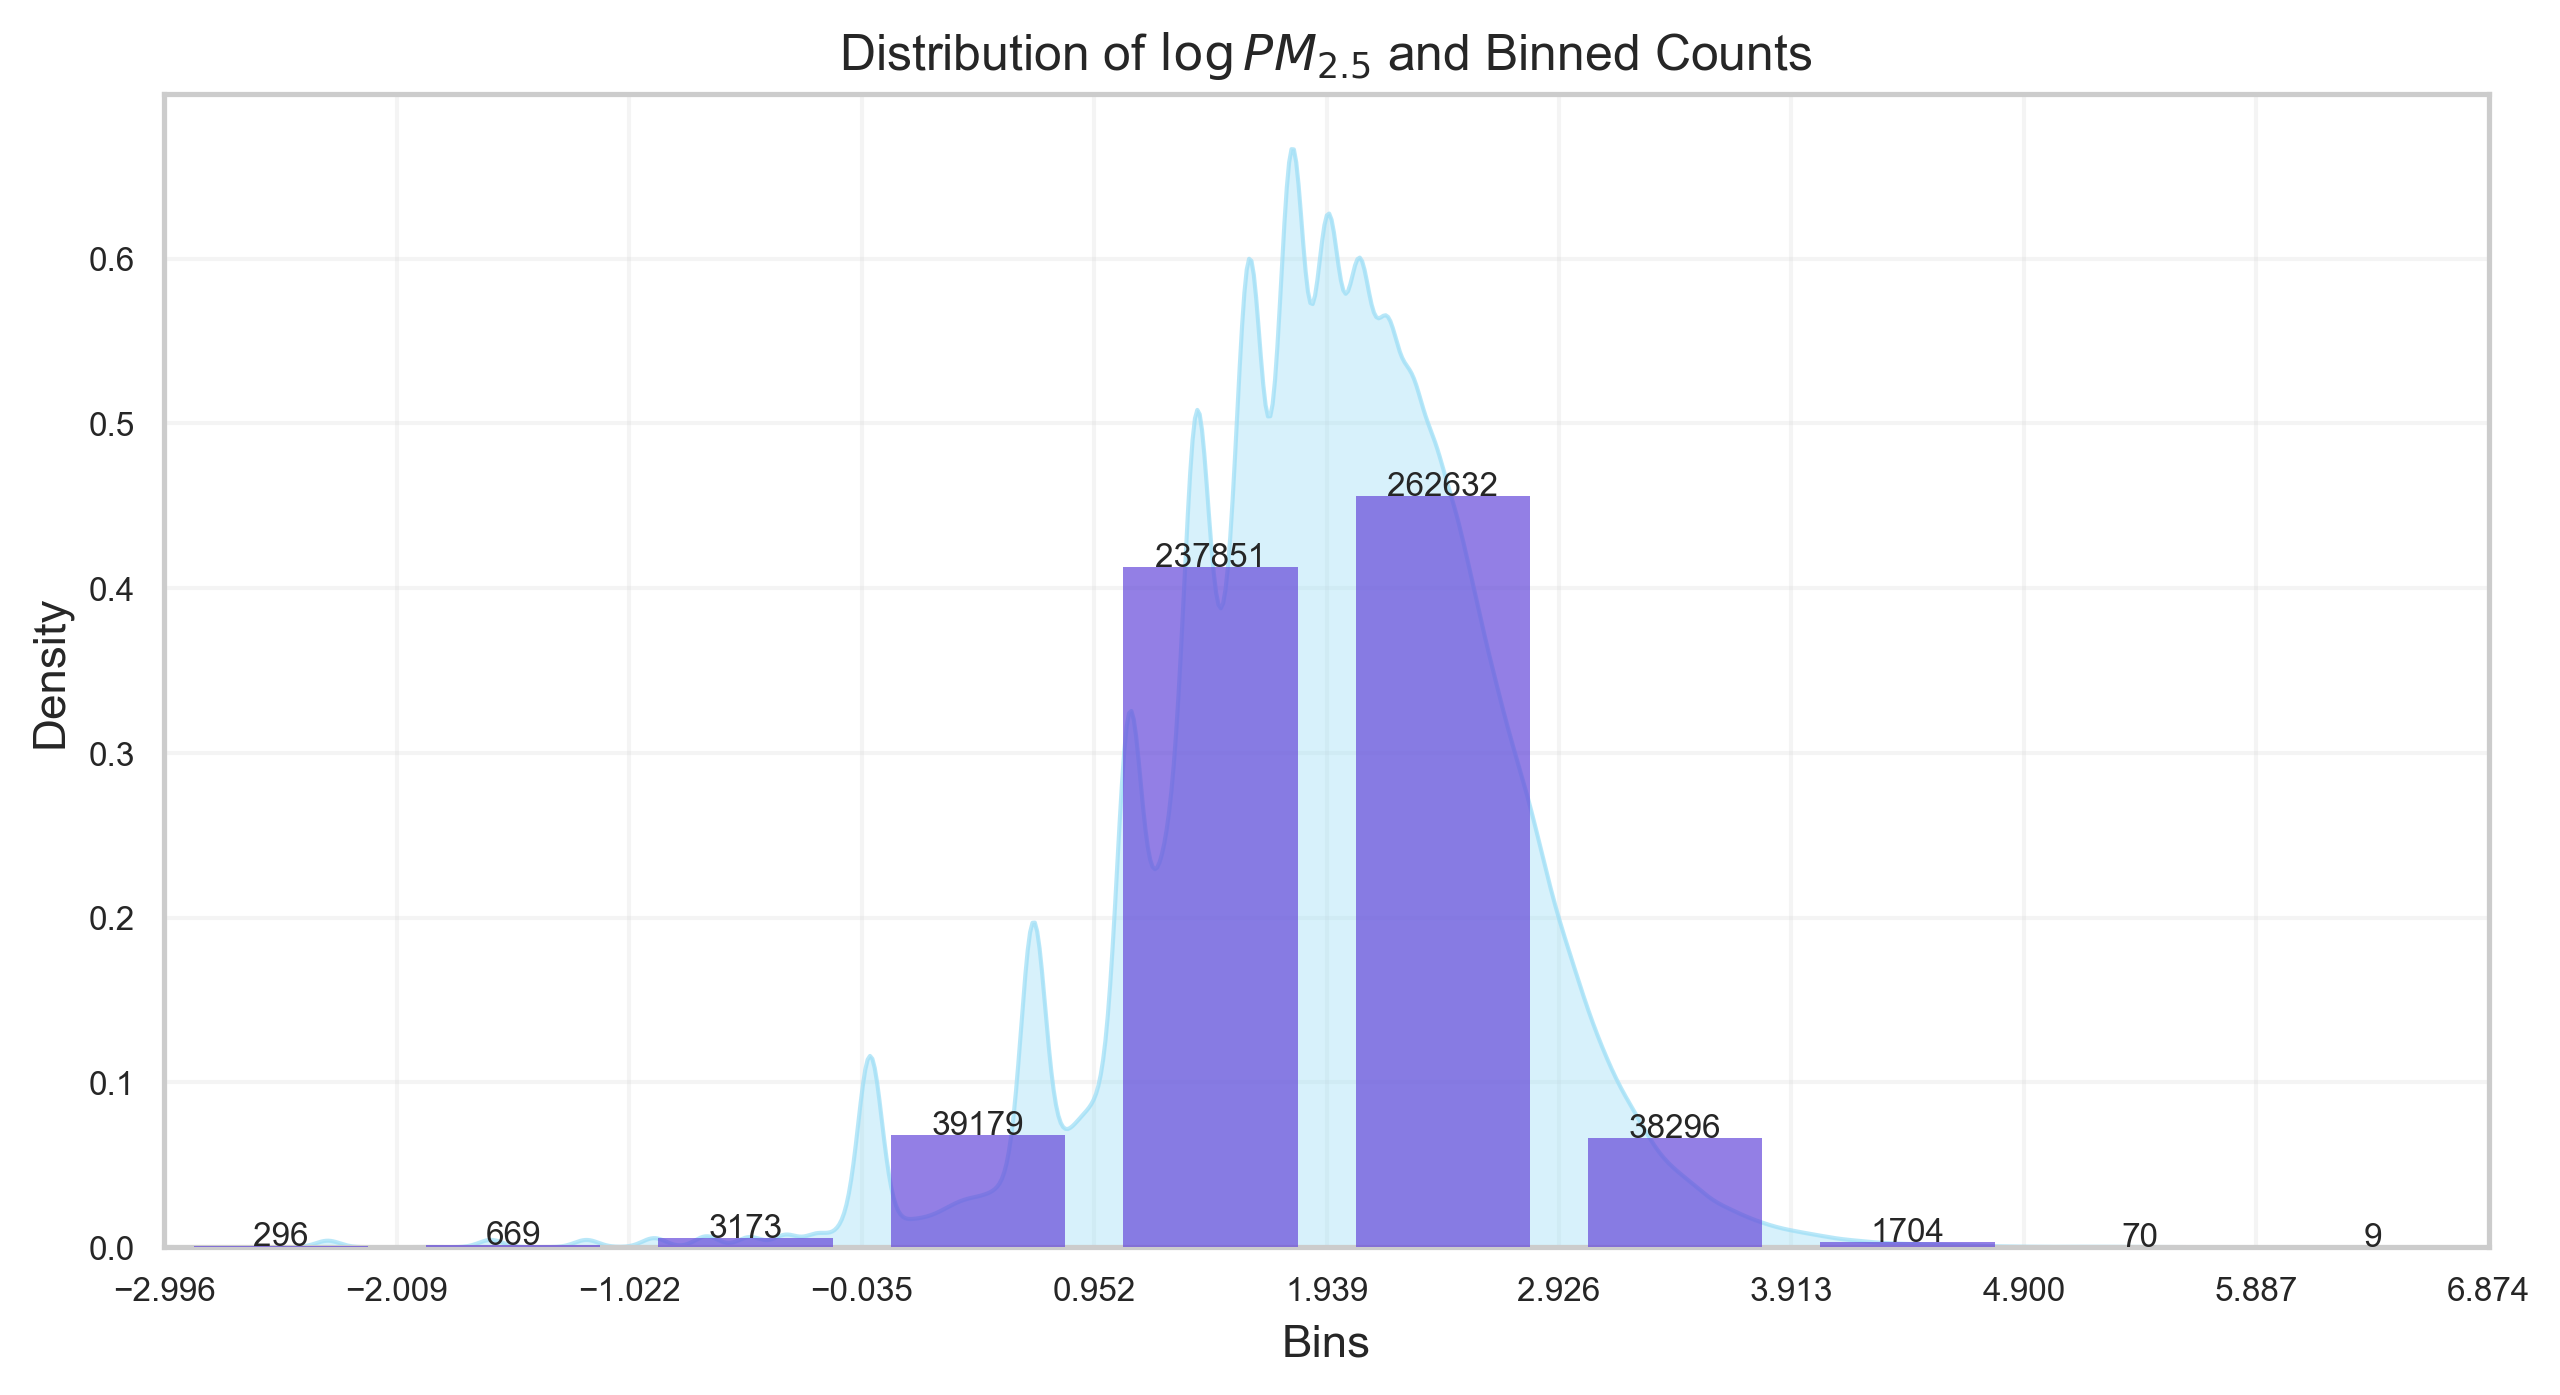

In [12]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $\log PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-3, 
                       ax=ax)

# plt.savefig(os.path.join(paths.figures, 'distribution.png'))

In [11]:
ax.get_xlim()

(-2.0, 6.8736812986483855)

In [32]:
bins

array([-2.99573227, -2.00879092, -1.02184956, -0.0349082 ,  0.95203316,
        1.93897451,  2.92591587,  3.91285723,  4.89979858,  5.88673994,
        6.8736813 ])

In [9]:
df['PM2.5'].describe()

count    583879.000000
mean          1.931888
std           0.720924
min          -2.995732
25%           1.526056
50%           1.945910
75%           2.397895
max           6.873681
Name: PM2.5, dtype: float64

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_52375/1319460639.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(hb, ax=ax1, label='counts')
/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_52375/1319460639.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(hb, ax=ax2, label='counts')


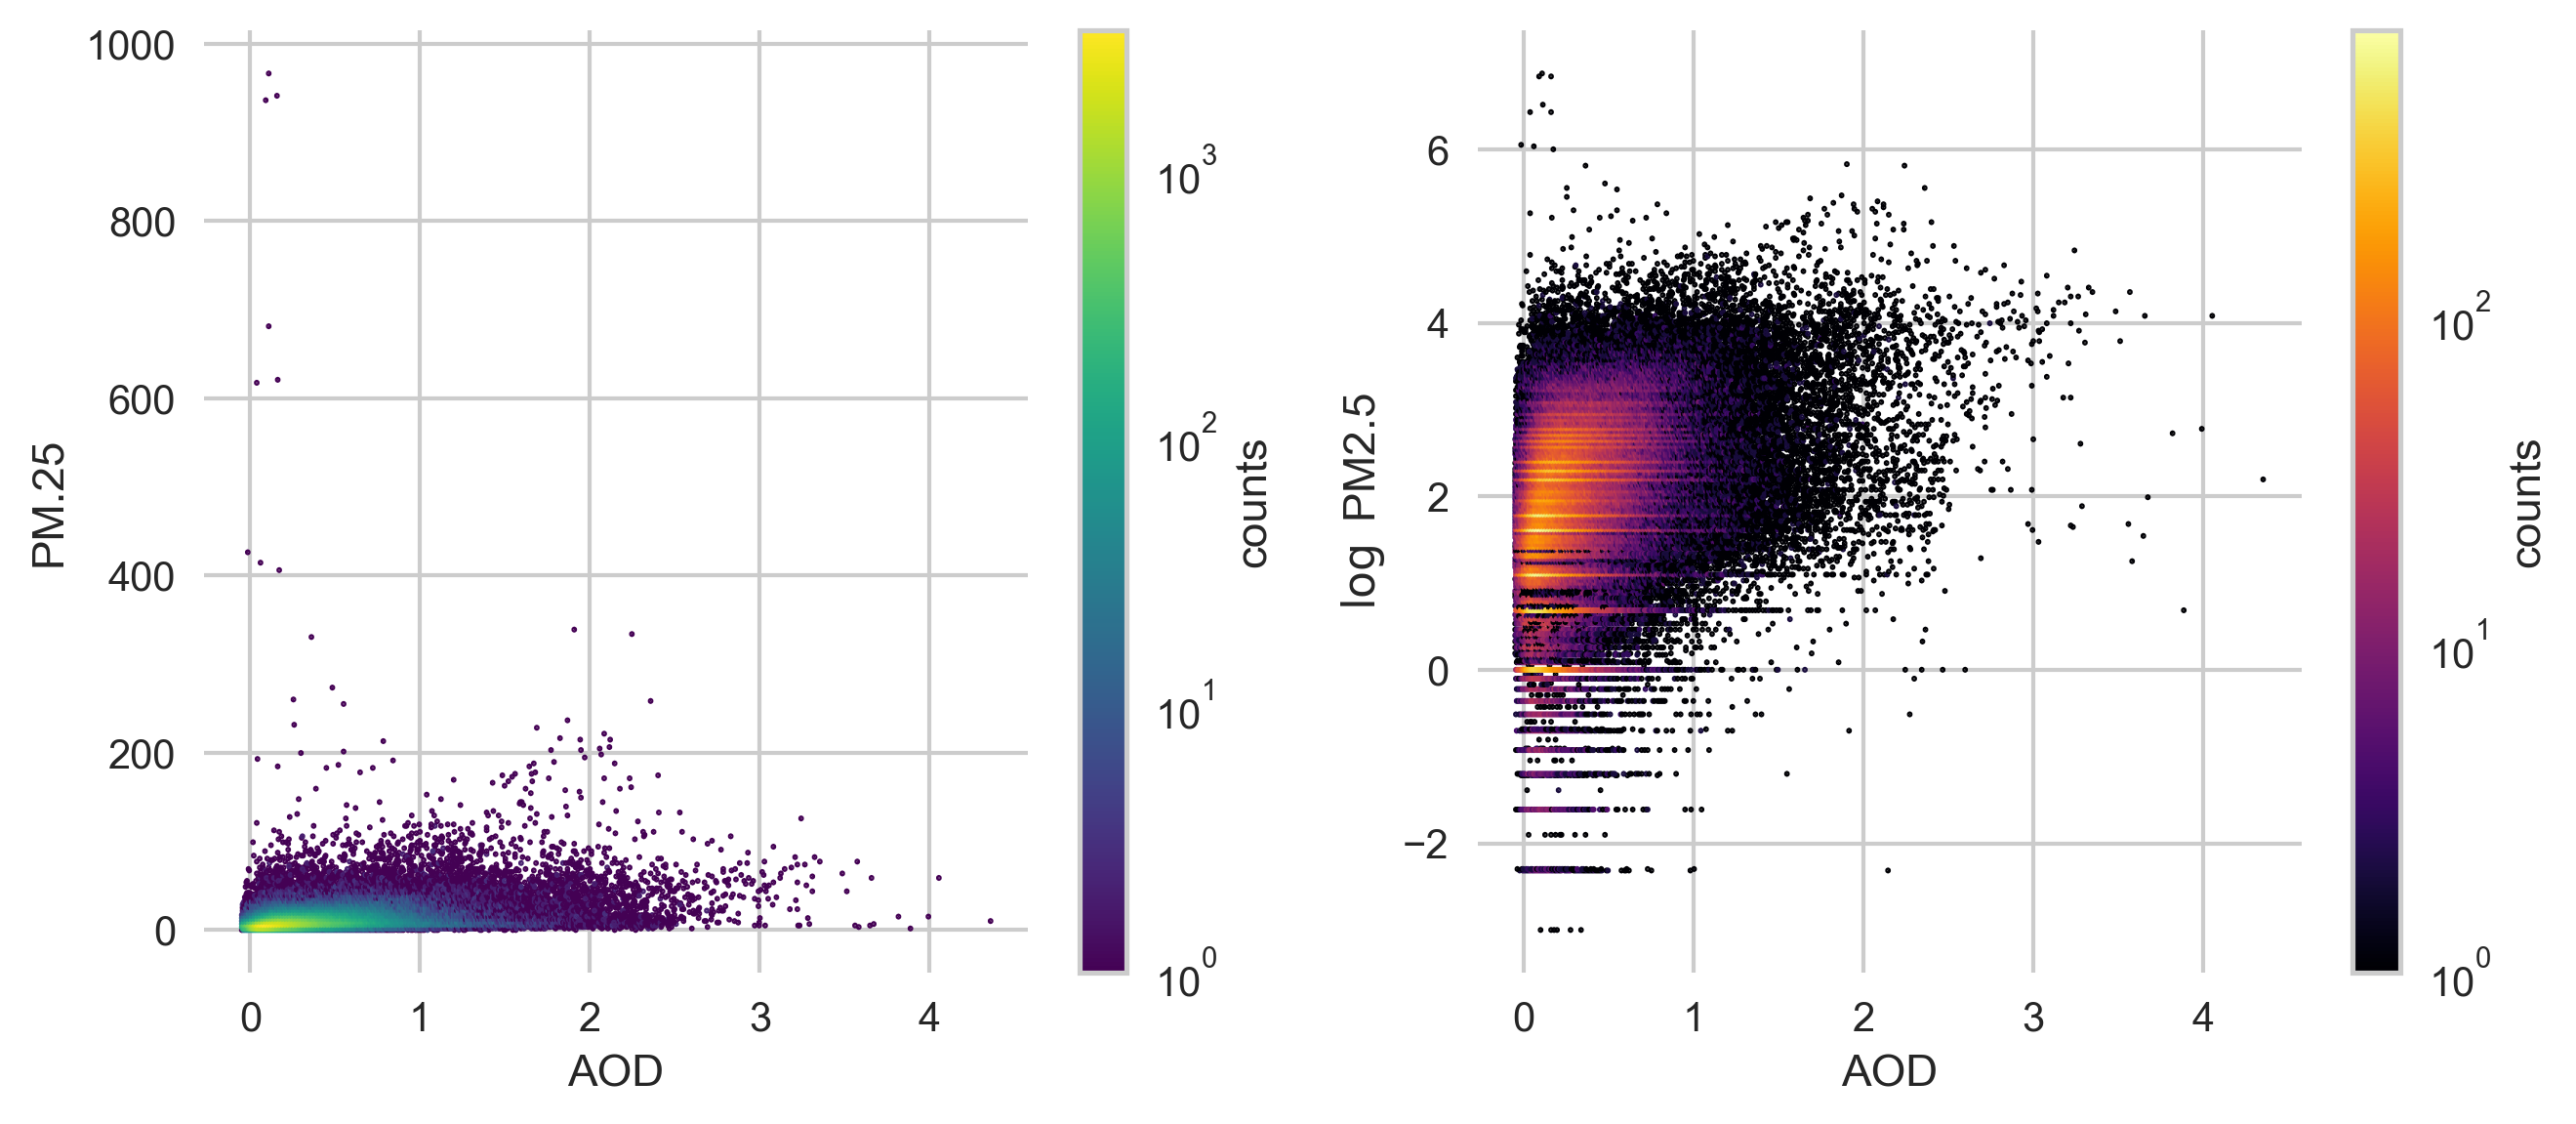

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(9, 4))

df = df[df['PM2.5'] > 0]

params = dict(bins='log', gridsize=500)
hb = ax1.hexbin(df.AOD, df['PM2.5'], cmap='viridis', **params)
cb = fig.colorbar(hb, ax=ax1, label='counts')

hb = ax2.hexbin(df.AOD, np.log(df['PM2.5']), cmap='inferno', **params)
cb = fig.colorbar(hb, ax=ax2, label='counts')

ax1.set_xlabel('AOD')
ax2.set_xlabel('AOD')

ax1.set_ylabel('PM.25')
ax2.set_ylabel('$\log$ PM2.5')

for spine in ['top', 'bottom', 'left', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
    
fig.tight_layout()

In [129]:
df

,AOD,PM2.5,longitude,latitude,time
0,0.082620,1.0,-68.770196,44.829549,2021-01-01 13:00:00
1,0.024902,1.0,-70.548633,44.562130,2021-01-01 13:00:00
2,0.032793,14.0,-70.217897,44.080211,2021-01-01 13:00:00
3,0.035074,6.5,-72.309845,43.642375,2021-01-01 13:00:00
4,0.136626,9.0,-70.256014,43.659906,2021-01-01 13:00:00
...,...,...,...,...,...
125,0.347638,4.9,-82.740894,27.948389,2021-12-31 21:00:00
126,0.242520,12.4,-80.227162,26.681993,2021-12-31 21:00:00
127,0.288910,3.1,-80.091584,26.465247,2021-12-31 21:00:00
128,0.138026,2.4,-115.212446,36.256789,2021-12-31 22:00:00


In [131]:
houston_data = df.copy()
for (lat, lon), v in houston.items():
    houston_data = houston_data.where((houston_data.latitude==lat) & (df.longitude==lon)).dropna()

(-95.2332660275758, 29.77665888146691)

In [134]:
lons, lats = list(map(list, zip(*houston.keys())))

In [138]:
data = df.where(df.latitude.isin(lats) & df.longitude.isin(lons)).dropna()

In [139]:
from model_collection import ModelCollection

In [140]:
data

,AOD,PM2.5,longitude,latitude,time
62,0.831489,3.0,-95.233266,29.776659,2021-01-02 14:00:00
490,0.083584,5.0,-95.233266,29.776659,2021-01-02 21:00:00
552,0.063961,1.0,-95.233266,29.776659,2021-01-02 22:00:00
552,0.096337,4.0,-95.233266,29.776659,2021-01-03 21:00:00
609,0.074356,3.0,-95.233266,29.776659,2021-01-03 22:00:00
...,...,...,...,...,...
2959,0.293007,15.3,-95.380616,29.803967,2021-09-26 21:00:00
3232,0.148121,43.5,-95.233266,29.776659,2021-09-27 22:00:00
3326,0.150510,4.0,-95.291869,29.823921,2021-09-27 23:00:00
3327,0.132940,11.9,-95.380616,29.803967,2021-09-27 23:00:00


In [167]:
data = data[data["PM2.5"] > 0]

In [181]:
X = data.AOD.values.reshape(-1, 1)
y = data["PM2.5"]

In [182]:
mc = ModelCollection(X, y)

In [183]:
mc.compute_cross_validation_scores()

  0%|          | 0/16 [00:00<?, ?it/s]

{'Linear Regression': {'fit_time': array([0.00095296, 0.00099707, 0.00075793, 0.00072908, 0.00082207,
         0.00097609, 0.00094295, 0.00078297, 0.00086713, 0.00100732]),
  'score_time': array([0.00095177, 0.001019  , 0.00082588, 0.00085902, 0.00092411,
         0.00109911, 0.00085998, 0.00086403, 0.00089598, 0.00087762]),
  'test_r2': array([ 0.04424518, -0.1736971 , -0.61086658,  0.04381876, -0.47445897,
          0.00844466, -0.05166745, -0.01380222,  0.00929404, -0.11798033]),
  'test_neg_mean_absolute_error': array([-7.42715096, -5.30400732, -5.60745185, -4.48729421, -6.58031977,
         -6.01983333, -5.85079769, -5.40572787, -7.01860841, -6.62450308]),
  'test_neg_root_mean_squared_error': array([-9.5125935 , -6.41669378, -6.79653471, -5.79553086, -8.17434532,
         -9.58670831, -7.73250086, -7.85362858, -8.84972038, -8.43448894])},
 'Elastic Net': {'fit_time': array([0.00109696, 0.0009501 , 0.00103402, 0.00080276, 0.0008657 ,
         0.0007472 , 0.00077987, 0.0007422 , 0.

In [184]:
mc.fit_model("Linear Regression")

0.0010080337524414062

In [185]:
mc.compute_scores_for_model("Linear Regression", X, y)

(0.051258348065642556, 7.8788867881481295, 5.909342301111386)

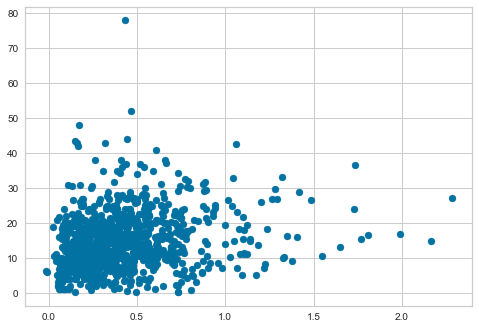

In [186]:
plt.scatter(X, y)

In [174]:
mc.models["Linear Regression"].intercept_

11.946513875066316